# Final Results for Multi-modal Approaches

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import tensorflow as tf 
import tensorflow_addons as tfa

from pathlib import Path
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, confusion_matrix, balanced_accuracy_score
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, ConvLSTM1D, Bidirectional, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant
from keras.layers.advanced_activations import PReLU

## Methods for loading datasets and creating model architectures

In [2]:
def load_file(file):
    df = pd.read_csv(file, header=0)
    labels = df['pain']
    df = df.drop(columns=['pain'])
    df.drop(df.columns[-1], axis=1, inplace=True)
    return df, labels

def load_dataset(input_filepath, modality):
    feature_names = []
    classes = []
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    train_filepath = data_dir / input_filepath / 'train' / modality
    test_filepath = data_dir / input_filepath / 'test' / modality
    # 1. Load train data
    X = list()
    y = list()
    for file in train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            if feature_names == []:
                feature_names = x.columns.values.tolist()
            if labels[0] not in classes:
                classes.append(labels[0])
            x = x.to_numpy()
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            x = x.to_numpy()
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test, feature_names, classes

def load_earlyfusion_dataset(input_filepath):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    body_train_filepath = data_dir / input_filepath / 'train' / 'skeleton'
    body_test_filepath = data_dir / input_filepath / 'test' / 'skeleton'
    face_train_filepath = data_dir / input_filepath / 'train' / 'AUs'
    face_test_filepath = data_dir / input_filepath / 'test' / 'AUs'
    head_train_filepath = data_dir / input_filepath / 'train' / 'pose'
    head_test_filepath = data_dir / input_filepath / 'test' / 'pose'
    # 1. Load train data
    X = list()
    y = list()
    for file in body_train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file)
            has_equivalent_face_file = False
            for second_file in face_train_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file)
                    head_x, head_labels = load_file(head_train_filepath / second_file.name)
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    full_X = np.concatenate((full_X, head_x), axis=1)
                    body_x = body_x.to_numpy()
                    face_x = face_x.to_numpy()
                    head_x = head_x.to_numpy()
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                continue
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in body_test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file)
            body_x = body_x.to_numpy()
            has_equivalent_face_file = False
            for second_file in face_test_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file)
                    head_x, head_labels = load_file(head_test_filepath / second_file.name)
                    face_x = face_x.to_numpy()
                    head_x = head_x.to_numpy()
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    full_X = np.concatenate((full_X, head_x), axis=1)
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                continue
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test

def load_latefusion_dataset(input_filepath, modality):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    train_filepath = data_dir / input_filepath / 'train' / modality
    test_filepath = data_dir / input_filepath / 'test' / modality
    # 1. Load train data
    X = list()
    y = list()
    for file in train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            if modality == 'skeleton':
                has_equivalent_face_file = False 
                for second_file in (data_dir / input_filepath / 'train' / 'AUs').iterdir():
                    if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                        has_equivalent_face_file = True
                        break
                if not has_equivalent_face_file:
                    continue
                else: 
                    x = x.to_numpy()
                    X.append(x)
                    y.append(labels[0])
            else:
                x = x.to_numpy()
                X.append(x)
                y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            if modality == 'skeleton':
                has_equivalent_face_file = False 
                for second_file in (data_dir / input_filepath / 'test' / 'AUs').iterdir():
                    if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                        has_equivalent_face_file = True
                        break
                if not has_equivalent_face_file:
                    continue
                else: 
                    x = x.to_numpy()
                    X.append(x)
                    y.append(labels[0])
            else:
                x = x.to_numpy()
                X.append(x)
                y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test

In [3]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
)

def train(model, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
    return history

def train_fusioned(model, body_X_train, face_X_train, head_X_train, y_train, body_X_val, face_X_val, head_X_val, y_val, epochs, batch_size, class_weight):
    history = model.fit([body_X_train, face_X_train, head_X_train], y_train, validation_data=([body_X_val, face_X_val, head_X_val], y_val), 
                        epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
    return history

### CNN + Bidirectional LSTM Model

This combination was developed for visual time series prediction problems and is popular in both activity recognition and pain assessment areas.
Bidrectional LSTM runs the input in two ways (past to future and future to past) making it possible to preserve information both backwards and forwards. I included this layer type anticipating it could be suited for making the model understand context to assess any experience of pain. 

Additionally, bidrectional LSTM is used by [Bargshady et al.](https://pubmed.ncbi.nlm.nih.gov/34756219/) in an Ensemble combination of CNN+BiLSTM models for facial expressions modality. Their settings: 

- filters: 256
- dense: 4096

Several previous work has used CNN+LSTM models, for example:

- [Yang et al.](https://arxiv.org/abs/2105.08822) to encode appearance changes and physiological cues from videos. 

- [Salekin et al.](https://arxiv.org/abs/2012.02175). Combines three modalities with (late) decision fusion. CNN filters start at 64 and gradually increses by a factor of 2 until 512. Used a small kernel size of 3, and follow with a pooling layer. Dense: 512. LSTM: 16 with activation tanh and recurrent activation hard sigmoid (because of binary classification). 

- [Haque et al.](https://ieeexplore-ieee-org.proxy.lnu.se/document/8373837) extracts RGB, thermal, depth features from videos and test two fusion strategies (early fusion received highest performance). LSTM hidden states vary between 64 and 256.

- [Rodriguez et al.](https://ieeexplore-ieee-org.proxy.lnu.se/document/7849133). Trying to make an end-to-end framework using VGGFace architecture + LSTM.

In [4]:
def build_CNNLSTM(n_features, n_length, n_outputs):
    input = Input(shape=(1, n_length, n_features))
    conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(input)
    conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(conv1d_1)
    maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d_2)
    conv1d_3 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(maxpool_1)
    conv1d_4 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(conv1d_3)
    maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d_4)
    flatten = TimeDistributed(Flatten())(maxpool_2)
    lstm_1 = Bidirectional(LSTM(100, return_sequences=True))(flatten)
    lstm_2 = Bidirectional(LSTM(100))(lstm_1)
    dense_1 = Dense(256, activation='tanh')(lstm_2)
    dense_2 = Dense(256, activation='tanh')(dense_1)
    output = Dense(units=n_outputs, activation='softmax')(dense_2)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

def build_fusioned_CNNLSTM(body_features, face_features, head_features, n_length, n_outputs):
    input_1 = Input(shape=(1, n_length, body_features))
    conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(input_1)
    conv1d_11 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(conv1d_1)
    bn_1 = TimeDistributed(BatchNormalization())(conv1d_11)
    maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_1)
    conv1d_111 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(maxpool_1)
    conv1d_1111 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(conv1d_111)
    bn_11 = TimeDistributed(BatchNormalization())(conv1d_1111)
    maxpool_11 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_11)
    flatten_1 = TimeDistributed(Flatten())(maxpool_11)
    lstm_1 = Bidirectional(LSTM(100, return_sequences=True))(flatten_1)
    lstm_11 = Bidirectional(LSTM(100))(lstm_1)
    dense_1 = Dense(256, activation='tanh')(lstm_11)
    dense_11 = Dense(256, activation='tanh')(dense_1)

    input_2 = Input(shape=(1, n_length, face_features))
    conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(input_2)
    conv1d_22 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(conv1d_2)
    bn_2 = TimeDistributed(BatchNormalization())(conv1d_22)
    maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_2)
    conv1d_222 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(maxpool_2)
    conv1d_2222 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(conv1d_222)
    bn_22 = TimeDistributed(BatchNormalization())(conv1d_2222)
    maxpool_22 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_22)
    flatten_2 = TimeDistributed(Flatten())(maxpool_22)
    lstm_2 = Bidirectional(LSTM(100, return_sequences=True))(flatten_2)
    lstm_22 = Bidirectional(LSTM(100))(lstm_2)
    dense_2 = Dense(256, activation='tanh')(lstm_22)
    dense_22 = Dense(256, activation='tanh')(dense_2)

    input_3 = Input(shape=(1, n_length, head_features))
    conv1d_3 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(input_3)
    conv1d_33 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(conv1d_3)
    bn_3 = TimeDistributed(BatchNormalization())(conv1d_33)
    maxpool_3 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_3)
    conv1d_333 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(maxpool_3)
    conv1d_3333 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='tanh'))(conv1d_333)
    bn_33 = TimeDistributed(BatchNormalization())(conv1d_3333)
    maxpool_33 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_33)
    flatten_3 = TimeDistributed(Flatten())(maxpool_33)
    lstm_3 = Bidirectional(LSTM(100, return_sequences=True))(flatten_3)
    lstm_33 = Bidirectional(LSTM(100))(lstm_3)
    dense_3 = Dense(256, activation='tanh')(lstm_33)
    dense_33 = Dense(256, activation='tanh')(dense_3)

    concat = Concatenate()([dense_11, dense_22, dense_33])
    output = Dense(units=n_outputs, activation='softmax')(concat)
    model = Model(inputs=[input_1, input_2, input_3], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

In [91]:
def build_convLSTM(n_features, n_length, n_outputs):
    input = Input(shape=(1, n_length, n_features))
    convlstm_1 = Bidirectional(ConvLSTM1D(filters=84, kernel_size=(3), activation='tanh', return_sequences=True))(input)
    convlstm_2 = Bidirectional(ConvLSTM1D(filters=84, kernel_size=(3), activation='tanh'))(convlstm_1)
    flatten = Flatten()(convlstm_2)
    dense_1 = Dense(256, activation='tanh')(flatten)
    dense_2 = Dense(256, activation='tanh')(dense_1)
    output = Dense(units=n_outputs, activation='softmax')(dense_2)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

def build_fusioned_convLSTM(body_features, face_features, head_features, n_length, n_outputs):
    input_1 = Input(shape=(1, n_length, body_features))
    convlstm_1 = Bidirectional(ConvLSTM1D(filters=84, kernel_size=(3), activation='tanh', return_sequences=True))(input_1)
    convlstm_11 = Bidirectional(ConvLSTM1D(filters=84, kernel_size=(3), activation='tanh'))(convlstm_1)
    flatten_1 = Flatten()(convlstm_11)
    dense_1 = Dense(256, activation='tanh')(flatten_1)
    dense_11 = Dense(256, activation='tanh')(dense_1)

    input_2 = Input(shape=(1, n_length, face_features))
    convlstm_2 = Bidirectional(ConvLSTM1D(filters=84, kernel_size=(3), activation='tanh', return_sequences=True))(input_2)
    convlstm_22 = Bidirectional(ConvLSTM1D(filters=84, kernel_size=(3), activation='tanh'))(convlstm_2)
    flatten_2 = Flatten()(convlstm_22)
    dense_2 = Dense(256, activation='tanh')(flatten_2)
    dense_22 = Dense(256, activation='tanh')(dense_2)

    input_3 = Input(shape=(1, n_length, head_features))
    convlstm_3 = Bidirectional(ConvLSTM1D(filters=84, kernel_size=(3), activation='tanh', return_sequences=True))(input_3)
    convlstm_33 = Bidirectional(ConvLSTM1D(filters=84, kernel_size=(3), activation='tanh'))(convlstm_3)
    flatten_3 = Flatten()(convlstm_33)
    dense_3 = Dense(256, activation='tanh')(flatten_3)
    dense_33 = Dense(256, activation='tanh')(dense_3)

    concat = Concatenate()([dense_11, dense_22, dense_33])
    output = Dense(units=n_outputs, activation='softmax')(concat)
    model = Model(inputs=[input_1, input_2, input_3], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

### RCNN (Recurrent CNN) Model

A network that has both convolutional and recurrent convolutional layers, or adding recurrent connections within every convolutional layer of a feed-forward CNN.

Additionally, RCNN is used by [Zhou et al.](https://ieeexplore-ieee-org.proxy.lnu.se/document/7789681) with video input for pain intensity prediction using PSPI.

In [97]:
def build_RCNN(n_features, n_length, n_outputs):
   input = Input(shape=(1, n_length, n_features))
   conv1d_1 = TimeDistributed(Conv1D(filters=84, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
   bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
   maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_1)
   conv1d_2 = TimeDistributed(Conv1D(filters=84, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(maxpool_1)
   bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
   maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_2)
   flatten = Flatten()(maxpool_2)
   dense_1 = Dense(256)(flatten)
   dense_2 = Dense(256)(dense_1)
   output = Dense(units=n_outputs, activation='softmax')(dense_2)
   model = Model(inputs=input, outputs=output)
   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
   return model


def build_fusioned_RCNN(body_features, face_features, head_features, n_length, n_outputs):
   input_1 = Input(shape=(1, n_length, body_features))
   conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_1)
   conv1d_11 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(conv1d_1)
   bn_1 = TimeDistributed(BatchNormalization())(conv1d_11)
   maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_1)
   conv1d_111 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(maxpool_1)
   conv1d_1111 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(conv1d_111)
   bn_11 = TimeDistributed(BatchNormalization())(conv1d_1111)
   maxpool_11 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_11)
   flatten_1 = Flatten()(maxpool_11)
   dense_1 = Dense(256, activation='relu')(flatten_1)
   dense_11 = Dense(256, activation='relu')(dense_1)

   input_2 = Input(shape=(1, n_length, face_features))
   conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_2)
   conv1d_22 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(conv1d_2)
   bn_2 = TimeDistributed(BatchNormalization())(conv1d_22)
   maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_2)
   conv1d_222 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(maxpool_2)
   conv1d_2222 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(conv1d_222)
   bn_22 = TimeDistributed(BatchNormalization())(conv1d_2222)
   maxpool_22 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_22)
   flatten_2 = Flatten()(maxpool_22)
   dense_2 = Dense(256, activation='relu')(flatten_2)
   dense_22 = Dense(256, activation='relu')(dense_2)

   input_3 = Input(shape=(1, n_length, head_features))
   conv1d_3 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_3)
   conv1d_33 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(conv1d_3)
   bn_3 = TimeDistributed(BatchNormalization())(conv1d_33)
   maxpool_3 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_3)
   conv1d_333 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(maxpool_3)
   conv1d_3333 = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(conv1d_333)
   bn_33 = TimeDistributed(BatchNormalization())(conv1d_3333)
   maxpool_33 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_33)
   flatten_3 = Flatten()(maxpool_33)
   dense_3 = Dense(256, activation='relu')(flatten_3)
   dense_33 = Dense(256, activation='relu')(dense_3)

   concat = Concatenate()([dense_11, dense_22, dense_33])
   output = Dense(units=n_outputs, activation='softmax')(concat)
   model = Model(inputs=[input_1, input_2, input_3], outputs=[output])
   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
   return model

### Dirichlet Markov Ensemble with soft voting

The Dirichlet ensemble weights the ensemble members based on validation set performance. The weight optimization search is performed with randomized search based on the dirichlet distribution. 
    
Soft voting involves summing the predicted probability scores for each class label and predicting the class label with the largest probability.

In [7]:
class KerasMember():
    def __init__(self, name=None, keras_model=None, train_batches=None,
                 val_batches=None, submission_probs=None, keras_modelpath=None,
                 keras_kwargs={}):
        assert(name is not None)
        self.name = name
        self.model = keras_model
        self.submission_probs = submission_probs
        # Initialize Params
        self.val_probs = None
        self.train_probs = None
        self.val_classes = None
        self.train_classes = None
        if (keras_model is None) and (keras_modelpath is not None):
            self.load_kerasmodel(self.keras_modelpath, self.keras_kwargs)
        if train_batches is not None:
            self._calculate_train_predictions(train_batches)
        if val_batches is not None:
            self._calculate_val_predictions(val_batches)

    def _test_datatuple(self, datatuple):
        assert(len(datatuple) == 2)
        assert(datatuple[0].shape[0] == datatuple[1].shape[0])

    def _calculate_predictions(self, batches):
        if hasattr(batches, 'shuffle'):
            batches.reset()
            batches.shuffle = False
        if type(batches) is tuple:
            self._test_datatuple(batches)
            return self.model.predict(batches[0])
        return self.model.predict_generator(
            batches, steps=(batches.n // batches.batch_size) + 1, verbose=1)

    def _calculate_val_predictions(self, val_batches):
        if type(val_batches) is tuple:
            self.val_classes = val_batches[1]
        elif hasattr(val_batches, 'classes'):
            self.val_classes = np.array(val_batches.classes)
        elif hasattr(val_batches, 'y'):
            self.val_classes = np.array(val_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.val_probs = self._calculate_predictions(val_batches)
        return self.val_probs

    def _calculate_train_predictions(self, train_batches):
        if type(train_batches) is tuple:
            self.train_classes = train_batches[1]
        elif hasattr(train_batches, 'classes'):
            self.train_classes = np.array(train_batches.classes)
        elif hasattr(train_batches, 'y'):
            self.train_classes = np.array(train_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.train_probs = self._calculate_predictions(train_batches)
        return self.train_probs


In [8]:
def _calculate_metric(y_true, y_pred, metric=None):
    if metric is None:
        metric = roc_auc_score
    y_t = y_true
    y_p = y_pred
    if metric == roc_auc_score:
        return metric(y_t, y_p, multi_class='ovo')
    if y_true.ndim > 1:
        y_t = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:
        y_p = np.argmax(y_pred, axis=1)
    if metric is precision_recall_fscore_support:
        return precision_recall_fscore_support(y_t, y_p, average='macro')
    if metric is balanced_accuracy_score:
        return balanced_accuracy_score(y_t, y_p)
    return metric(y_t, y_p)

In [9]:
class DirichletEnsemble():
    def __init__(self, N=10000, metric=None, maximize=True):
        self.n = N
        self.metric = metric
        if metric is None:
            self.metric = roc_auc_score
        self.maximize = maximize
        # Initialize Parameters:
        self.members = []
        self.bestweights = []
        self.probabilities = None
        self._nmembers = 0
        self.bestscore = float("-inf") if maximize else float("inf")
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.fitted = False

    def add_members(self, members):
        for member in members:
            self.add_member(member)

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1

    def fit(self, verbose=False):
        assert(len(self.members) > 1)
        val_classes = self.members[0].val_classes
        best_ensemble_score = float("-inf") if self.maximize else float("inf")
        best_ensemble_accuracy = 0
        best_ensemble_balanced_acc = 0
        best_ensemble_p = 0
        best_ensemble_r = 0
        best_ensemble_f1 = 0
        rsbest = None
        for i in range(self.n):
            rs = np.random.dirichlet(np.ones(self._nmembers), size=1)[0]
            preds = np.sum(np.array([self.members[i].val_probs * rs[i]
                                     for i in range(self._nmembers)]), axis=0)
            ensemble_score = _calculate_metric(val_classes, preds)
            ensemble_accuracy = _calculate_metric(val_classes, preds, accuracy_score)
            ensemble_balanced_acc = _calculate_metric(val_classes, preds, balanced_accuracy_score)
            ensemble_prf1 = _calculate_metric(val_classes, preds, precision_recall_fscore_support)
            ensemble_p = ensemble_prf1[0]
            ensemble_r = ensemble_prf1[1]
            ensemble_f1 = ensemble_prf1[2]
            max_flag = self.maximize and ensemble_score > best_ensemble_score
            min_flag = not(
                self.maximize) and ensemble_score < best_ensemble_score
            if max_flag or min_flag:
                if verbose:
                    print(ensemble_score, i, rs) 
                best_ensemble_score = ensemble_score
                rsbest = rs
            if ensemble_accuracy > best_ensemble_accuracy:
                if verbose:
                    print(ensemble_accuracy, i, rs) 
                best_ensemble_accuracy = ensemble_accuracy
            if ensemble_balanced_acc > best_ensemble_balanced_acc:
                if verbose:
                    print(ensemble_balanced_acc, i, rs) 
                best_ensemble_balanced_acc = ensemble_balanced_acc
            if ensemble_p > best_ensemble_p:
                if verbose:
                    print(ensemble_p, i, rs) 
                best_ensemble_p = ensemble_p
            if ensemble_r > best_ensemble_r:
                if verbose:
                    print(ensemble_r, i, rs) 
                best_ensemble_r = ensemble_r
            if ensemble_f1 > best_ensemble_f1:
                if verbose:
                    print(ensemble_f1, i, rs) 
                best_ensemble_f1 = ensemble_f1
        self.bestweights = rsbest
        self.bestscore = best_ensemble_score
        self.accuracy = best_ensemble_accuracy
        self.balanced_acc = best_ensemble_balanced_acc
        self.precision = best_ensemble_p
        self.recall = best_ensemble_r
        self.f1 = best_ensemble_f1

    def predict(self):
        self.probabilities = np.sum(np.array([self.bestweights[i] *
                                              self.members[i].submission_probs
                                              for i in range(self._nmembers)]),
                                    axis=0)
        return self.probabilities
        
    def describe(self):
        for i in range(self._nmembers):
            member = self.members[i]
            text = member.name + " (weight: {:1.4f})".format(self.bestweights[i])
            print(text)
        print("\nAccuracy: {:1.2f}% \nBalanced Accuracy: {:1.2f}% \nROC/AUC: {:1.2f} \nPrecision: {:1.2f} \nRecall: {:1.2f} \nF1 score: {:1.2f}".format(
            self.accuracy * 100, self.balanced_acc * 100, self.bestscore, self.precision, self.recall, self.f1))
        return

### KFold CV

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
epochs, batch_size = 100, 64

## 1. Uni-modal approaches

Training the different model architectures on single modalities (skeleton vs action units). 

### About the data

In [11]:
full_body_X_train, full_body_X_test, full_body_y_train, full_body_y_test, body_feature_names, classes = load_dataset('processed', 'skeleton')
full_body_X = full_body_X_train.copy()
full_body_y = full_body_y_train.copy()

print(full_body_X_train.shape, full_body_y_train.shape)
print(full_body_X_test.shape, full_body_y_test.shape)

n_length, body_features, body_outputs = full_body_X_train.shape[2], full_body_X_train.shape[-1], full_body_y_test.shape[1]

(552, 1, 350, 38) (552, 4)
(63, 1, 350, 38) (63, 4)


In [12]:
umild, lmoderate, lmild, umoderate = np.sum(full_body_y, axis=0)
total = umild + lmoderate + lmild + umoderate

print(classes[0], ':', umild, '({:.1f}% of total)'.format(umild / total * 100))
print(classes[2], ':', lmild, '({:.1f}% of total)'.format(lmild / total * 100))
print(classes[1], ':', lmoderate, '({:.1f}% of total)'.format(lmoderate / total * 100))
print(classes[3], ':', umoderate, '({:.1f}% of total)'.format(umoderate / total * 100))

LowerBody Mild : 219 (39.7% of total)
UpperBody Moderate : 132 (23.9% of total)
UpperBody Mild : 120 (21.7% of total)
LowerBody Moderate : 81 (14.7% of total)


In [13]:
weight_for_0 = (1 / umild) * (total / 2.0)
weight_for_1 = (1 / lmoderate) * (total / 2.0)
weight_for_2 = (1 / lmild) * (total / 2.0)
weight_for_3 = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))

Weight for class 0: 1.26
Weight for class 1: 2.30
Weight for class 2: 2.09
Weight for class 3: 3.41


### 1.1 Body modality (skeleton) models

#### Train CNN+LSTM

In [14]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 13s - loss: 1.4064 - accuracy: 0.3107 - auc: 0.5828 - precision: 0.3594 - recall: 0.0522 - f1_score: 0.2031 - val_loss: 1.3381 - val_accuracy: 0.3874 - val_auc: 0.6112 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.1396 - 13s/epoch - 2s/step
Epoch 2/100
7/7 - 0s - loss: 1.3320 - accuracy: 0.3991 - auc: 0.6231 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.1426 - val_loss: 1.3342 - val_accuracy: 0.3874 - val_auc: 0.6276 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.1396 - 227ms/epoch - 32ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3347 - accuracy: 0.3991 - auc: 0.6089 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.1426 - val_loss: 1.3314 - val_accuracy: 0.3874 - val_auc: 0.6276 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.1396 - 211ms/epoch - 30ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3294 - accuracy: 0.3991 - auc: 0.6182 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 

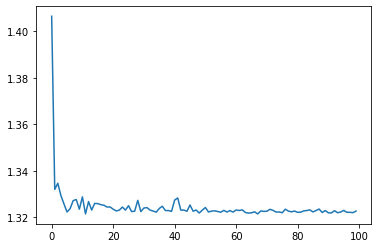

Epoch 1/100
7/7 - 6s - loss: 1.3807 - accuracy: 0.3288 - auc_1: 0.5816 - precision_1: 0.3438 - recall_1: 0.0499 - f1_score: 0.1825 - val_loss: 1.2993 - val_accuracy: 0.4685 - val_auc_1: 0.6066 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.1595 - 6s/epoch - 822ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3620 - accuracy: 0.3787 - auc_1: 0.5888 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.1373 - val_loss: 1.2916 - val_accuracy: 0.4685 - val_auc_1: 0.6907 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.1595 - 212ms/epoch - 30ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3418 - accuracy: 0.3787 - auc_1: 0.6114 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.1373 - val_loss: 1.2750 - val_accuracy: 0.4685 - val_auc_1: 0.6517 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.1595 - 216ms/epoch - 31ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3387 - accuracy: 0.3787 - auc_1: 0.6119 - precision_1: 0.0

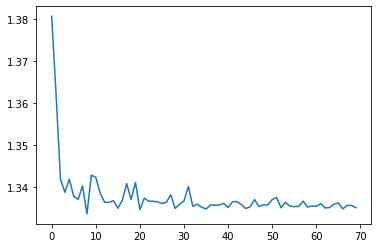

Epoch 1/100
7/7 - 6s - loss: 1.3733 - accuracy: 0.3665 - auc_2: 0.6009 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.1814 - val_loss: 1.3544 - val_accuracy: 0.4000 - val_auc_2: 0.6173 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.1429 - 6s/epoch - 882ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3264 - accuracy: 0.3959 - auc_2: 0.6257 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.1418 - val_loss: 1.3470 - val_accuracy: 0.4000 - val_auc_2: 0.6061 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.1429 - 212ms/epoch - 30ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3294 - accuracy: 0.3959 - auc_2: 0.6265 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.1418 - val_loss: 1.3360 - val_accuracy: 0.4000 - val_auc_2: 0.6061 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.1429 - 231ms/epoch - 33ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3223 - accuracy: 0.3959 - auc_2: 0.6234 - precisio

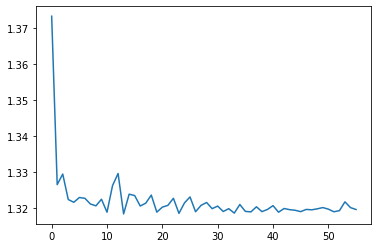

Epoch 1/100
7/7 - 6s - loss: 1.3848 - accuracy: 0.3439 - auc_3: 0.5915 - precision_3: 0.3125 - recall_3: 0.0452 - f1_score: 0.1999 - val_loss: 1.3558 - val_accuracy: 0.3818 - val_auc_3: 0.5939 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1382 - 6s/epoch - 883ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3323 - accuracy: 0.4005 - auc_3: 0.6261 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.1430 - val_loss: 1.3605 - val_accuracy: 0.3818 - val_auc_3: 0.6061 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1382 - 187ms/epoch - 27ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3340 - accuracy: 0.4005 - auc_3: 0.6302 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.1430 - val_loss: 1.3439 - val_accuracy: 0.3818 - val_auc_3: 0.6061 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1382 - 223ms/epoch - 32ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3242 - accuracy: 0.4005 - auc_3: 0.6275 - precision_3: 0.0

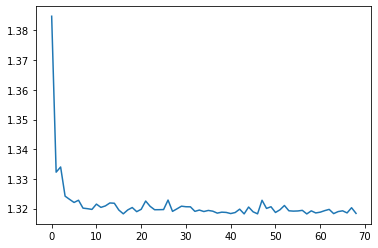

Epoch 1/100
7/7 - 6s - loss: 1.3773 - accuracy: 0.2851 - auc_4: 0.5890 - precision_4: 0.4219 - recall_4: 0.0611 - f1_score: 0.2067 - val_loss: 1.3518 - val_accuracy: 0.3455 - val_auc_4: 0.6121 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.1284 - 6s/epoch - 868ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3336 - accuracy: 0.4095 - auc_4: 0.5946 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - f1_score: 0.1453 - val_loss: 1.3635 - val_accuracy: 0.3455 - val_auc_4: 0.6175 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.1284 - 176ms/epoch - 25ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3313 - accuracy: 0.4095 - auc_4: 0.6138 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - f1_score: 0.1453 - val_loss: 1.3460 - val_accuracy: 0.3455 - val_auc_4: 0.6098 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.1284 - 221ms/epoch - 32ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3409 - accuracy: 0.3620 - auc_4: 0.6106 - precision_4: 0.0

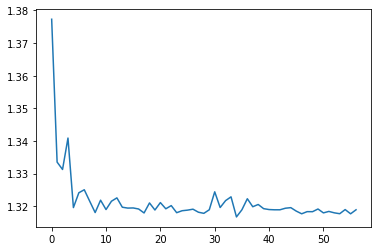

In [15]:
body_cnnlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'body_cnnlstm.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(full_body_X):
    X_train, X_val = full_body_X[train_index], full_body_X[val_index]
    y_train, y_val = full_body_y[train_index], full_body_y[val_index]
    body_cnnlstm = build_CNNLSTM(body_features, n_length, body_outputs)
    history = train(body_cnnlstm, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        body_cnnlstm.save(body_cnnlstm_model_path)

In [16]:
body_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_cnnlstm_train_results

{'Accuracy': 0.39673203229904175,
 'ROC/AUC': 0.6235702395439148,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1-score': 0.14200275540351867}

In [17]:
body_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_cnnlstm_val_results

{'Accuracy': 0.3966257154941559,
 'ROC/AUC': 0.6246082425117493,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1-score': 0.141702601313591}

#### Train ConvLSTM

In [18]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 10s - loss: 2.8184 - accuracy: 0.3039 - auc_5: 0.5788 - precision_5: 0.3257 - recall_5: 0.2245 - f1_score: 0.2120 - val_loss: 1.7456 - val_accuracy: 0.2523 - val_auc_5: 0.5257 - val_precision_5: 0.2523 - val_recall_5: 0.2523 - val_f1_score: 0.1007 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.5272 - accuracy: 0.2449 - auc_5: 0.5230 - precision_5: 0.3471 - recall_5: 0.0952 - f1_score: 0.2020 - val_loss: 1.4924 - val_accuracy: 0.3874 - val_auc_5: 0.5655 - val_precision_5: 0.3874 - val_recall_5: 0.3874 - val_f1_score: 0.1396 - 789ms/epoch - 113ms/step
Epoch 3/100
7/7 - 1s - loss: 1.3937 - accuracy: 0.3855 - auc_5: 0.6258 - precision_5: 0.4102 - recall_5: 0.2381 - f1_score: 0.1806 - val_loss: 1.4034 - val_accuracy: 0.2523 - val_auc_5: 0.5255 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.1007 - 798ms/epoch - 114ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3620 - accuracy: 0.3265 - auc_5: 0.5863 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 

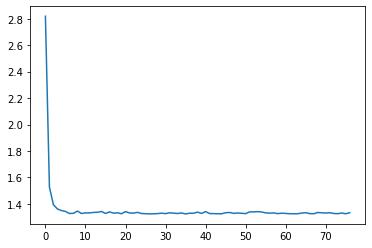

Epoch 1/100
7/7 - 10s - loss: 2.8419 - accuracy: 0.2971 - auc_6: 0.5665 - precision_6: 0.2964 - recall_6: 0.1882 - f1_score: 0.2232 - val_loss: 1.5884 - val_accuracy: 0.4685 - val_auc_6: 0.6914 - val_precision_6: 0.4685 - val_recall_6: 0.4685 - val_f1_score: 0.1595 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.5314 - accuracy: 0.3039 - auc_6: 0.5631 - precision_6: 0.4453 - recall_6: 0.1293 - f1_score: 0.2396 - val_loss: 1.5083 - val_accuracy: 0.1261 - val_auc_6: 0.3784 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.0560 - 768ms/epoch - 110ms/step
Epoch 3/100
7/7 - 1s - loss: 1.4314 - accuracy: 0.3333 - auc_6: 0.5794 - precision_6: 0.2807 - recall_6: 0.0363 - f1_score: 0.1554 - val_loss: 1.3051 - val_accuracy: 0.4685 - val_auc_6: 0.6907 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.1595 - 779ms/epoch - 111ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3959 - accuracy: 0.3605 - auc_6: 0.6103 - precision_6: 0.0000e+00 - recall_6: 0.0

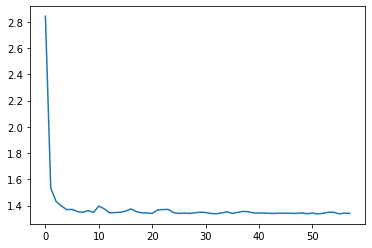

Epoch 1/100
7/7 - 10s - loss: 2.5475 - accuracy: 0.2851 - auc_7: 0.6013 - precision_7: 0.3333 - recall_7: 0.2353 - f1_score: 0.2337 - val_loss: 2.0779 - val_accuracy: 0.2182 - val_auc_7: 0.5515 - val_precision_7: 0.2182 - val_recall_7: 0.2182 - val_f1_score: 0.0896 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.6042 - accuracy: 0.3258 - auc_7: 0.5456 - precision_7: 0.1875 - recall_7: 0.0543 - f1_score: 0.1763 - val_loss: 1.5411 - val_accuracy: 0.4000 - val_auc_7: 0.5939 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.1429 - 783ms/epoch - 112ms/step
Epoch 3/100
7/7 - 1s - loss: 1.4168 - accuracy: 0.3959 - auc_7: 0.6171 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - f1_score: 0.1418 - val_loss: 1.4598 - val_accuracy: 0.4000 - val_auc_7: 0.6121 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.1429 - 785ms/epoch - 112ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3852 - accuracy: 0.3959 - auc_7: 0.6065 - precision_7: 0.0000e+00 - recal

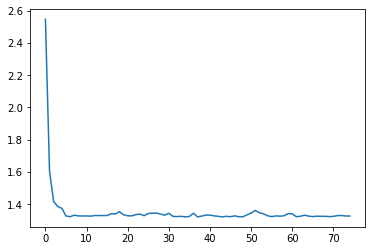

Epoch 1/100
7/7 - 9s - loss: 3.0036 - accuracy: 0.3371 - auc_8: 0.5848 - precision_8: 0.3677 - recall_8: 0.3145 - f1_score: 0.2264 - val_loss: 1.3389 - val_accuracy: 0.3818 - val_auc_8: 0.6118 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_f1_score: 0.1382 - 9s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.6354 - accuracy: 0.2376 - auc_8: 0.4618 - precision_8: 0.2266 - recall_8: 0.0656 - f1_score: 0.1981 - val_loss: 1.3881 - val_accuracy: 0.3818 - val_auc_8: 0.6091 - val_precision_8: 0.3818 - val_recall_8: 0.3818 - val_f1_score: 0.1382 - 737ms/epoch - 105ms/step
Epoch 3/100
7/7 - 1s - loss: 1.4400 - accuracy: 0.3394 - auc_8: 0.6269 - precision_8: 0.3984 - recall_8: 0.2308 - f1_score: 0.1824 - val_loss: 1.5218 - val_accuracy: 0.2182 - val_auc_8: 0.5515 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_f1_score: 0.0896 - 741ms/epoch - 106ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3841 - accuracy: 0.3756 - auc_8: 0.6145 - precision_8: 0.3750 - recall_8: 0.0543 - 

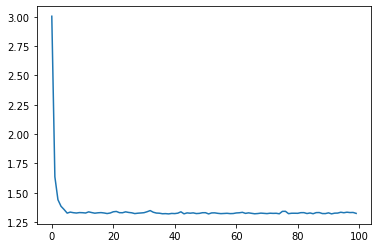

Epoch 1/100
7/7 - 10s - loss: 3.1239 - accuracy: 0.2647 - auc_9: 0.5330 - precision_9: 0.3000 - recall_9: 0.2172 - f1_score: 0.2213 - val_loss: 1.7762 - val_accuracy: 0.1182 - val_auc_9: 0.4091 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_f1_score: 0.0528 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.6219 - accuracy: 0.2421 - auc_9: 0.5378 - precision_9: 0.2739 - recall_9: 0.1946 - f1_score: 0.1807 - val_loss: 1.6679 - val_accuracy: 0.3455 - val_auc_9: 0.6152 - val_precision_9: 0.3455 - val_recall_9: 0.3455 - val_f1_score: 0.1284 - 783ms/epoch - 112ms/step
Epoch 3/100
7/7 - 1s - loss: 1.4954 - accuracy: 0.3529 - auc_9: 0.6142 - precision_9: 0.3789 - recall_9: 0.2195 - f1_score: 0.1875 - val_loss: 1.4619 - val_accuracy: 0.2636 - val_auc_9: 0.5333 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_f1_score: 0.1043 - 778ms/epoch - 111ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3918 - accuracy: 0.3552 - auc_9: 0.5711 - precision_9: 0.0000e+00 - recall_9: 0.0

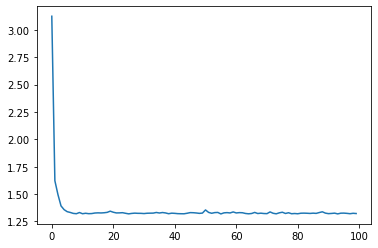

In [19]:
body_convlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'body_convlstm.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(full_body_X):
    X_train, X_val = full_body_X[train_index], full_body_X[val_index]
    y_train, y_val = full_body_y[train_index], full_body_y[val_index]
    body_convLSTM = build_convLSTM(body_features, n_length, body_outputs)
    history = train(body_convLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        body_convLSTM.save(body_convlstm_model_path)

In [20]:
body_convlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_convlstm_train_results

{'Accuracy': 0.39673203229904175,
 'ROC/AUC': 0.619655990600586,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1-score': 0.14200275540351867}

In [21]:
body_convlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_convlstm_val_results

{'Accuracy': 0.3966257154941559,
 'ROC/AUC': 0.6216134190559387,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1-score': 0.141702601313591}

#### Train RCNN

In [22]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 2s - loss: 43.7900 - accuracy: 0.3039 - auc_10: 0.5534 - precision_10: 0.3059 - recall_10: 0.2948 - f1_score: 0.2639 - val_loss: 492.8607 - val_accuracy: 0.2162 - val_auc_10: 0.4775 - val_precision_10: 0.2162 - val_recall_10: 0.2162 - val_f1_score: 0.0889 - 2s/epoch - 230ms/step
Epoch 2/100
7/7 - 0s - loss: 16.4696 - accuracy: 0.3764 - auc_10: 0.6012 - precision_10: 0.3799 - recall_10: 0.3764 - f1_score: 0.3496 - val_loss: 143.0132 - val_accuracy: 0.3874 - val_auc_10: 0.5916 - val_precision_10: 0.3874 - val_recall_10: 0.3874 - val_f1_score: 0.1396 - 134ms/epoch - 19ms/step
Epoch 3/100
7/7 - 0s - loss: 7.8788 - accuracy: 0.3243 - auc_10: 0.5575 - precision_10: 0.3256 - recall_10: 0.3175 - f1_score: 0.3117 - val_loss: 54.2751 - val_accuracy: 0.2523 - val_auc_10: 0.5015 - val_precision_10: 0.2523 - val_recall_10: 0.2523 - val_f1_score: 0.1007 - 127ms/epoch - 18ms/step
Epoch 4/100
7/7 - 0s - loss: 4.9215 - accuracy: 0.3583 - auc_10: 0.6215 - precision_10: 0.3550 - recall_

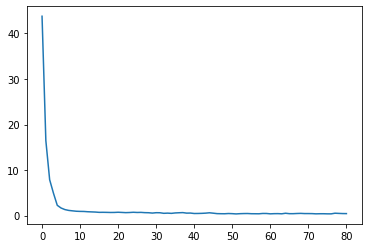

Epoch 1/100
7/7 - 2s - loss: 39.1936 - accuracy: 0.2404 - auc_11: 0.4913 - precision_11: 0.2354 - recall_11: 0.2290 - f1_score: 0.2014 - val_loss: 175.5197 - val_accuracy: 0.1441 - val_auc_11: 0.4329 - val_precision_11: 0.1441 - val_recall_11: 0.1441 - val_f1_score: 0.0630 - 2s/epoch - 226ms/step
Epoch 2/100
7/7 - 0s - loss: 16.1920 - accuracy: 0.3379 - auc_11: 0.5765 - precision_11: 0.3386 - recall_11: 0.3379 - f1_score: 0.3121 - val_loss: 141.2043 - val_accuracy: 0.1441 - val_auc_11: 0.4294 - val_precision_11: 0.1441 - val_recall_11: 0.1441 - val_f1_score: 0.0630 - 126ms/epoch - 18ms/step
Epoch 3/100
7/7 - 0s - loss: 6.6627 - accuracy: 0.3628 - auc_11: 0.5854 - precision_11: 0.3689 - recall_11: 0.3605 - f1_score: 0.3423 - val_loss: 32.3338 - val_accuracy: 0.4685 - val_auc_11: 0.6456 - val_precision_11: 0.4685 - val_recall_11: 0.4685 - val_f1_score: 0.1595 - 130ms/epoch - 19ms/step
Epoch 4/100
7/7 - 0s - loss: 4.4550 - accuracy: 0.3560 - auc_11: 0.6190 - precision_11: 0.3652 - recall_

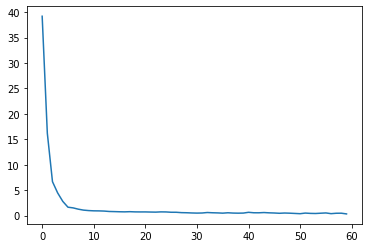

Epoch 1/100
7/7 - 2s - loss: 22.4027 - accuracy: 0.2919 - auc_12: 0.5369 - precision_12: 0.2952 - recall_12: 0.2805 - f1_score: 0.2732 - val_loss: 130.9675 - val_accuracy: 0.2364 - val_auc_12: 0.4914 - val_precision_12: 0.2364 - val_recall_12: 0.2364 - val_f1_score: 0.1686 - 2s/epoch - 232ms/step
Epoch 2/100
7/7 - 0s - loss: 9.4960 - accuracy: 0.3145 - auc_12: 0.5576 - precision_12: 0.3128 - recall_12: 0.3100 - f1_score: 0.2803 - val_loss: 132.4158 - val_accuracy: 0.2000 - val_auc_12: 0.4667 - val_precision_12: 0.2000 - val_recall_12: 0.2000 - val_f1_score: 0.0833 - 121ms/epoch - 17ms/step
Epoch 3/100
7/7 - 0s - loss: 5.0505 - accuracy: 0.3258 - auc_12: 0.5798 - precision_12: 0.3262 - recall_12: 0.3122 - f1_score: 0.2645 - val_loss: 21.9528 - val_accuracy: 0.2182 - val_auc_12: 0.4804 - val_precision_12: 0.2182 - val_recall_12: 0.2182 - val_f1_score: 0.1220 - 129ms/epoch - 18ms/step
Epoch 4/100
7/7 - 0s - loss: 2.7055 - accuracy: 0.3597 - auc_12: 0.6135 - precision_12: 0.3655 - recall_1

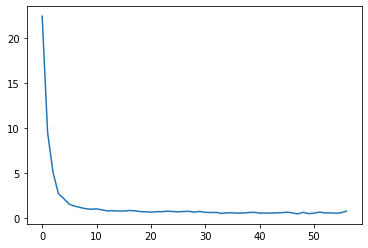

Epoch 1/100
7/7 - 2s - loss: 37.0544 - accuracy: 0.2828 - auc_13: 0.5274 - precision_13: 0.2881 - recall_13: 0.2783 - f1_score: 0.2593 - val_loss: 505.9724 - val_accuracy: 0.3818 - val_auc_13: 0.5879 - val_precision_13: 0.3818 - val_recall_13: 0.3818 - val_f1_score: 0.1382 - 2s/epoch - 227ms/step
Epoch 2/100
7/7 - 0s - loss: 14.9341 - accuracy: 0.3484 - auc_13: 0.5603 - precision_13: 0.3477 - recall_13: 0.3462 - f1_score: 0.3076 - val_loss: 73.8599 - val_accuracy: 0.2727 - val_auc_13: 0.5247 - val_precision_13: 0.2727 - val_recall_13: 0.2727 - val_f1_score: 0.1568 - 127ms/epoch - 18ms/step
Epoch 3/100
7/7 - 0s - loss: 6.2180 - accuracy: 0.3937 - auc_13: 0.6299 - precision_13: 0.4005 - recall_13: 0.3869 - f1_score: 0.3289 - val_loss: 67.0294 - val_accuracy: 0.3818 - val_auc_13: 0.5879 - val_precision_13: 0.3818 - val_recall_13: 0.3818 - val_f1_score: 0.1382 - 125ms/epoch - 18ms/step
Epoch 4/100
7/7 - 0s - loss: 3.7846 - accuracy: 0.3145 - auc_13: 0.5910 - precision_13: 0.3236 - recall_1

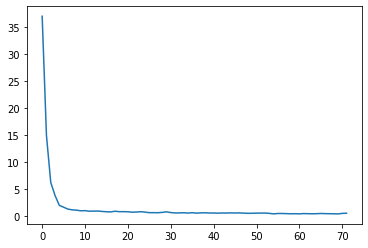

Epoch 1/100
7/7 - 2s - loss: 28.0891 - accuracy: 0.3167 - auc_14: 0.5535 - precision_14: 0.3222 - recall_14: 0.3054 - f1_score: 0.2778 - val_loss: 519.0103 - val_accuracy: 0.2636 - val_auc_14: 0.5091 - val_precision_14: 0.2636 - val_recall_14: 0.2636 - val_f1_score: 0.1043 - 2s/epoch - 223ms/step
Epoch 2/100
7/7 - 0s - loss: 10.2778 - accuracy: 0.3303 - auc_14: 0.5814 - precision_14: 0.3341 - recall_14: 0.3258 - f1_score: 0.2969 - val_loss: 73.3329 - val_accuracy: 0.3455 - val_auc_14: 0.5636 - val_precision_14: 0.3455 - val_recall_14: 0.3455 - val_f1_score: 0.1284 - 130ms/epoch - 19ms/step
Epoch 3/100
7/7 - 0s - loss: 4.5709 - accuracy: 0.3552 - auc_14: 0.6122 - precision_14: 0.3605 - recall_14: 0.3303 - f1_score: 0.3192 - val_loss: 104.2690 - val_accuracy: 0.1182 - val_auc_14: 0.4121 - val_precision_14: 0.1182 - val_recall_14: 0.1182 - val_f1_score: 0.0528 - 122ms/epoch - 17ms/step
Epoch 4/100
7/7 - 0s - loss: 3.1425 - accuracy: 0.3394 - auc_14: 0.6072 - precision_14: 0.3528 - recall_

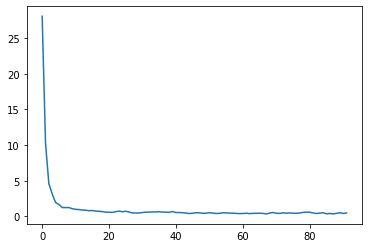

In [23]:
body_rcnn_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'body_rcnn.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(full_body_X):
    X_train, X_val = full_body_X[train_index], full_body_X[val_index]
    y_train, y_val = full_body_y[train_index], full_body_y[val_index]
    body_rcnn = build_RCNN(body_features, n_length, body_outputs)
    history = train(body_rcnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        body_rcnn.save(body_rcnn_model_path)

In [24]:
body_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_rcnn_train_results

{'Accuracy': 0.8301864385604858,
 'ROC/AUC': 0.9592704057693482,
 'Precision': 0.8374305009841919,
 'Recall': 0.8138865828514099,
 'F1-score': 0.8238590240478516}

In [25]:
body_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_rcnn_val_results

{'Accuracy': 0.35502047538757325,
 'ROC/AUC': 0.600057053565979,
 'Precision': 0.3541633188724518,
 'Recall': 0.32969696521759034,
 'F1-score': 0.2980451464653015}

### 1.2 Face modality (Action units)

#### About the data

In [82]:
face_X_train, face_X_test, face_y_train, face_y_test, face_feature_names, c = load_dataset('processed', 'AUs')
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

n_length, face_features, face_outputs = face_X_train.shape[2], face_X_train.shape[-1], face_y_train.shape[1]

(537, 1, 350, 10) (537, 4)
(60, 1, 350, 10) (60, 4)


In [27]:
umild, lmoderate, lmild, umoderate = np.sum(face_y, axis=0)
total = umild + lmoderate + lmild + umoderate

weight_for_0 = (1 / umild) * (total / 2.0)
weight_for_1 = (1 / lmoderate) * (total / 2.0)
weight_for_2 = (1 / lmild) * (total / 2.0)
weight_for_3 = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

#### Train CNN+LSTM

In [28]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 6s - loss: 1.3483 - accuracy: 0.3753 - auc_15: 0.6156 - precision_15: 0.5227 - recall_15: 0.0536 - f1_score: 0.2289 - val_loss: 1.3080 - val_accuracy: 0.3796 - val_auc_15: 0.6487 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.1376 - 6s/epoch - 792ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3044 - accuracy: 0.4009 - auc_15: 0.6552 - precision_15: 0.4375 - recall_15: 0.0326 - f1_score: 0.2018 - val_loss: 1.3658 - val_accuracy: 0.2870 - val_auc_15: 0.6032 - val_precision_15: 1.0000 - val_recall_15: 0.0093 - val_f1_score: 0.2118 - 169ms/epoch - 24ms/step
Epoch 3/100
7/7 - 0s - loss: 1.2798 - accuracy: 0.4056 - auc_15: 0.6731 - precision_15: 0.7917 - recall_15: 0.0443 - f1_score: 0.2487 - val_loss: 1.3242 - val_accuracy: 0.3611 - val_auc_15: 0.6434 - val_precision_15: 0.6364 - val_recall_15: 0.0648 - val_f1_score: 0.1790 - 169ms/epoch - 24ms/step
Epoch 4/100
7/7 - 0s - loss: 1.2327 - accuracy: 0.4289 - auc_15: 0.7036 - precision_15: 0.5865 - recall

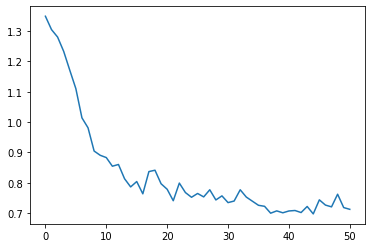

Epoch 1/100
7/7 - 6s - loss: 1.3488 - accuracy: 0.3776 - auc_16: 0.6154 - precision_16: 0.3684 - recall_16: 0.0163 - f1_score: 0.2201 - val_loss: 1.3607 - val_accuracy: 0.3796 - val_auc_16: 0.6009 - val_precision_16: 0.5500 - val_recall_16: 0.1019 - val_f1_score: 0.1376 - 6s/epoch - 818ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3009 - accuracy: 0.3939 - auc_16: 0.6543 - precision_16: 0.4783 - recall_16: 0.0513 - f1_score: 0.1418 - val_loss: 1.3287 - val_accuracy: 0.3981 - val_auc_16: 0.6359 - val_precision_16: 0.4167 - val_recall_16: 0.0463 - val_f1_score: 0.2199 - 209ms/epoch - 30ms/step
Epoch 3/100
7/7 - 0s - loss: 1.2553 - accuracy: 0.4079 - auc_16: 0.6861 - precision_16: 0.5526 - recall_16: 0.0979 - f1_score: 0.1855 - val_loss: 1.3174 - val_accuracy: 0.3889 - val_auc_16: 0.6438 - val_precision_16: 0.5417 - val_recall_16: 0.1204 - val_f1_score: 0.2007 - 210ms/epoch - 30ms/step
Epoch 4/100
7/7 - 0s - loss: 1.2157 - accuracy: 0.4545 - auc_16: 0.7194 - precision_16: 0.6058 - recall_16: 0.1

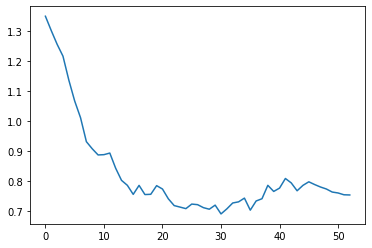

Epoch 1/100
7/7 - 6s - loss: 1.3416 - accuracy: 0.3930 - auc_17: 0.6165 - precision_17: 0.4400 - recall_17: 0.0256 - f1_score: 0.2331 - val_loss: 1.3910 - val_accuracy: 0.3832 - val_auc_17: 0.5991 - val_precision_17: 0.4314 - val_recall_17: 0.2056 - val_f1_score: 0.1385 - 6s/epoch - 852ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3146 - accuracy: 0.4070 - auc_17: 0.6437 - precision_17: 0.5072 - recall_17: 0.0814 - f1_score: 0.1776 - val_loss: 1.3448 - val_accuracy: 0.3738 - val_auc_17: 0.6106 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00 - val_f1_score: 0.1919 - 208ms/epoch - 30ms/step
Epoch 3/100
7/7 - 0s - loss: 1.2656 - accuracy: 0.4163 - auc_17: 0.6805 - precision_17: 0.6769 - recall_17: 0.1023 - f1_score: 0.2125 - val_loss: 1.3696 - val_accuracy: 0.4112 - val_auc_17: 0.6223 - val_precision_17: 0.4828 - val_recall_17: 0.1308 - val_f1_score: 0.2432 - 170ms/epoch - 24ms/step
Epoch 4/100
7/7 - 0s - loss: 1.2480 - accuracy: 0.4186 - auc_17: 0.6892 - precision_17: 0.6364 - recall

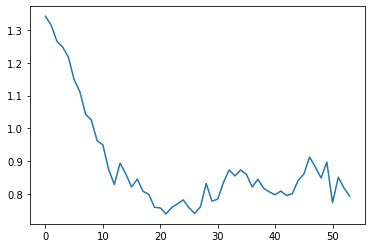

Epoch 1/100
7/7 - 6s - loss: 1.3831 - accuracy: 0.3465 - auc_18: 0.5844 - precision_18: 0.3750 - recall_18: 0.0349 - f1_score: 0.2214 - val_loss: 1.3053 - val_accuracy: 0.3832 - val_auc_18: 0.6638 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.1395 - 6s/epoch - 790ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3140 - accuracy: 0.4023 - auc_18: 0.6430 - precision_18: 0.5263 - recall_18: 0.0465 - f1_score: 0.1761 - val_loss: 1.2915 - val_accuracy: 0.4112 - val_auc_18: 0.6613 - val_precision_18: 0.6923 - val_recall_18: 0.0841 - val_f1_score: 0.1853 - 215ms/epoch - 31ms/step
Epoch 3/100
7/7 - 0s - loss: 1.2780 - accuracy: 0.4047 - auc_18: 0.6741 - precision_18: 0.5417 - recall_18: 0.0302 - f1_score: 0.1895 - val_loss: 1.2856 - val_accuracy: 0.3925 - val_auc_18: 0.6663 - val_precision_18: 0.6250 - val_recall_18: 0.0935 - val_f1_score: 0.1799 - 211ms/epoch - 30ms/step
Epoch 4/100
7/7 - 0s - loss: 1.2399 - accuracy: 0.4419 - auc_18: 0.6980 - precision_18: 0.6154 - recall

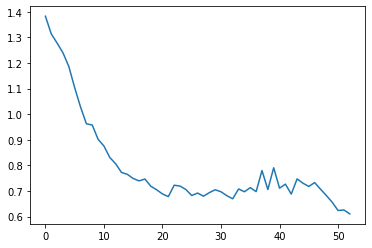

Epoch 1/100
7/7 - 6s - loss: 1.3733 - accuracy: 0.3023 - auc_19: 0.5589 - precision_19: 0.4643 - recall_19: 0.0302 - f1_score: 0.2344 - val_loss: 1.2815 - val_accuracy: 0.4486 - val_auc_19: 0.6918 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - val_f1_score: 0.1548 - 6s/epoch - 869ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3193 - accuracy: 0.3837 - auc_19: 0.6399 - precision_19: 0.6000 - recall_19: 0.0070 - f1_score: 0.1387 - val_loss: 1.3666 - val_accuracy: 0.4486 - val_auc_19: 0.5985 - val_precision_19: 1.0000 - val_recall_19: 0.0093 - val_f1_score: 0.1548 - 173ms/epoch - 25ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3184 - accuracy: 0.3884 - auc_19: 0.6374 - precision_19: 0.5484 - recall_19: 0.0395 - f1_score: 0.1488 - val_loss: 1.2828 - val_accuracy: 0.4393 - val_auc_19: 0.6768 - val_precision_19: 0.5238 - val_recall_19: 0.1028 - val_f1_score: 0.1536 - 167ms/epoch - 24ms/step
Epoch 4/100
7/7 - 0s - loss: 1.2678 - accuracy: 0.3791 - auc_19: 0.6739 - precision_19: 0.6184 - recall

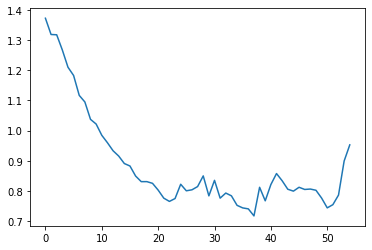

In [29]:
face_cnnlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'face_cnnlstm.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(face_X):
    X_train, X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = face_y[train_index], face_y[val_index]
    face_cnnlstm = build_CNNLSTM(face_features, n_length, face_outputs)
    history = train(face_cnnlstm, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        face_cnnlstm.save(face_cnnlstm_model_path)

In [30]:
face_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_cnnlstm_train_results

{'Accuracy': 0.6312907218933106,
 'ROC/AUC': 0.8858333587646484,
 'Precision': 0.8354843735694886,
 'Recall': 0.5144392073154449,
 'F1-score': 0.6117014169692994}

In [31]:
face_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_cnnlstm_val_results

{'Accuracy': 0.3630668044090271,
 'ROC/AUC': 0.6307712316513061,
 'Precision': 0.4329781115055084,
 'Recall': 0.2682416081428528,
 'F1-score': 0.27893707156181335}

#### Train ConvLSTM

In [32]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 10s - loss: 1.4119 - accuracy: 0.3333 - auc_20: 0.5861 - precision_20: 0.4746 - recall_20: 0.0653 - f1_score: 0.2593 - val_loss: 1.3215 - val_accuracy: 0.3796 - val_auc_20: 0.6434 - val_precision_20: 0.4545 - val_recall_20: 0.0926 - val_f1_score: 0.1376 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.2949 - accuracy: 0.4079 - auc_20: 0.6597 - precision_20: 0.6308 - recall_20: 0.0956 - f1_score: 0.2267 - val_loss: 1.3064 - val_accuracy: 0.3611 - val_auc_20: 0.6588 - val_precision_20: 0.6250 - val_recall_20: 0.0463 - val_f1_score: 0.2065 - 751ms/epoch - 107ms/step
Epoch 3/100
7/7 - 1s - loss: 1.2512 - accuracy: 0.4336 - auc_20: 0.6954 - precision_20: 0.6196 - recall_20: 0.1329 - f1_score: 0.3130 - val_loss: 1.4274 - val_accuracy: 0.3148 - val_auc_20: 0.5501 - val_precision_20: 0.2308 - val_recall_20: 0.0278 - val_f1_score: 0.2537 - 734ms/epoch - 105ms/step
Epoch 4/100
7/7 - 1s - loss: 1.2208 - accuracy: 0.4359 - auc_20: 0.7096 - precision_20: 0.6800 - recall_20: 0.

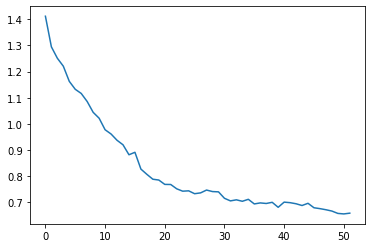

Epoch 1/100
7/7 - 10s - loss: 1.4209 - accuracy: 0.2960 - auc_21: 0.5519 - precision_21: 0.3889 - recall_21: 0.0490 - f1_score: 0.2619 - val_loss: 1.3672 - val_accuracy: 0.3889 - val_auc_21: 0.6011 - val_precision_21: 0.5833 - val_recall_21: 0.1296 - val_f1_score: 0.1604 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.3032 - accuracy: 0.3893 - auc_21: 0.6623 - precision_21: 0.5000 - recall_21: 0.1049 - f1_score: 0.2173 - val_loss: 1.4354 - val_accuracy: 0.2407 - val_auc_21: 0.5593 - val_precision_21: 0.1111 - val_recall_21: 0.0185 - val_f1_score: 0.1695 - 744ms/epoch - 106ms/step
Epoch 3/100
7/7 - 1s - loss: 1.2610 - accuracy: 0.4079 - auc_21: 0.6816 - precision_21: 0.5513 - recall_21: 0.1002 - f1_score: 0.2769 - val_loss: 1.4148 - val_accuracy: 0.3333 - val_auc_21: 0.6085 - val_precision_21: 0.4167 - val_recall_21: 0.0926 - val_f1_score: 0.1770 - 758ms/epoch - 108ms/step
Epoch 4/100
7/7 - 1s - loss: 1.2247 - accuracy: 0.4336 - auc_21: 0.7045 - precision_21: 0.5729 - recall_21: 0.

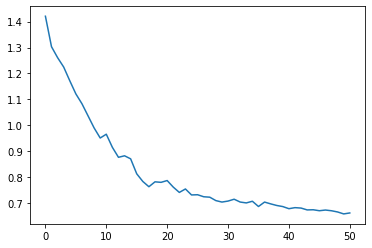

Epoch 1/100
7/7 - 9s - loss: 1.4221 - accuracy: 0.2977 - auc_22: 0.5669 - precision_22: 0.3958 - recall_22: 0.0884 - f1_score: 0.2569 - val_loss: 1.3838 - val_accuracy: 0.3364 - val_auc_22: 0.5946 - val_precision_22: 0.4500 - val_recall_22: 0.0841 - val_f1_score: 0.2261 - 9s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.3176 - accuracy: 0.3814 - auc_22: 0.6441 - precision_22: 0.5732 - recall_22: 0.1093 - f1_score: 0.2282 - val_loss: 1.3457 - val_accuracy: 0.3925 - val_auc_22: 0.6174 - val_precision_22: 0.4444 - val_recall_22: 0.0374 - val_f1_score: 0.2597 - 799ms/epoch - 114ms/step
Epoch 3/100
7/7 - 1s - loss: 1.2595 - accuracy: 0.4326 - auc_22: 0.6877 - precision_22: 0.5444 - recall_22: 0.1140 - f1_score: 0.3056 - val_loss: 1.3907 - val_accuracy: 0.4206 - val_auc_22: 0.6205 - val_precision_22: 0.3333 - val_recall_22: 0.1121 - val_f1_score: 0.2594 - 736ms/epoch - 105ms/step
Epoch 4/100
7/7 - 1s - loss: 1.2095 - accuracy: 0.4419 - auc_22: 0.7060 - precision_22: 0.6962 - recall_22: 0.12

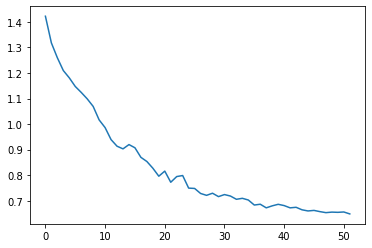

Epoch 1/100
7/7 - 10s - loss: 1.4201 - accuracy: 0.3023 - auc_23: 0.5518 - precision_23: 0.3158 - recall_23: 0.0419 - f1_score: 0.2544 - val_loss: 1.3249 - val_accuracy: 0.3738 - val_auc_23: 0.6462 - val_precision_23: 0.5417 - val_recall_23: 0.1215 - val_f1_score: 0.1370 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.2982 - accuracy: 0.4163 - auc_23: 0.6585 - precision_23: 0.5821 - recall_23: 0.0907 - f1_score: 0.1877 - val_loss: 1.2978 - val_accuracy: 0.4112 - val_auc_23: 0.6524 - val_precision_23: 0.5882 - val_recall_23: 0.0935 - val_f1_score: 0.1919 - 790ms/epoch - 113ms/step
Epoch 3/100
7/7 - 1s - loss: 1.2577 - accuracy: 0.4233 - auc_23: 0.6875 - precision_23: 0.7213 - recall_23: 0.1023 - f1_score: 0.2636 - val_loss: 1.2662 - val_accuracy: 0.3551 - val_auc_23: 0.6769 - val_precision_23: 0.6000 - val_recall_23: 0.0561 - val_f1_score: 0.1610 - 806ms/epoch - 115ms/step
Epoch 4/100
7/7 - 1s - loss: 1.2116 - accuracy: 0.4628 - auc_23: 0.7149 - precision_23: 0.7206 - recall_23: 0.

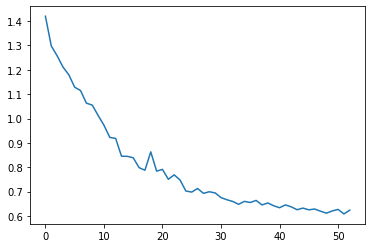

Epoch 1/100
7/7 - 10s - loss: 1.4598 - accuracy: 0.2953 - auc_24: 0.5437 - precision_24: 0.3579 - recall_24: 0.0791 - f1_score: 0.2420 - val_loss: 1.3068 - val_accuracy: 0.4486 - val_auc_24: 0.6509 - val_precision_24: 0.5263 - val_recall_24: 0.0935 - val_f1_score: 0.1569 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.3256 - accuracy: 0.3535 - auc_24: 0.6253 - precision_24: 0.5172 - recall_24: 0.0349 - f1_score: 0.2316 - val_loss: 1.2896 - val_accuracy: 0.4486 - val_auc_24: 0.6713 - val_precision_24: 0.5161 - val_recall_24: 0.1495 - val_f1_score: 0.1558 - 786ms/epoch - 112ms/step
Epoch 3/100
7/7 - 1s - loss: 1.2832 - accuracy: 0.3977 - auc_24: 0.6696 - precision_24: 0.5345 - recall_24: 0.0721 - f1_score: 0.2317 - val_loss: 1.2818 - val_accuracy: 0.4673 - val_auc_24: 0.6832 - val_precision_24: 0.5000 - val_recall_24: 0.0935 - val_f1_score: 0.2464 - 784ms/epoch - 112ms/step
Epoch 4/100
7/7 - 1s - loss: 1.2481 - accuracy: 0.4349 - auc_24: 0.6928 - precision_24: 0.6463 - recall_24: 0.

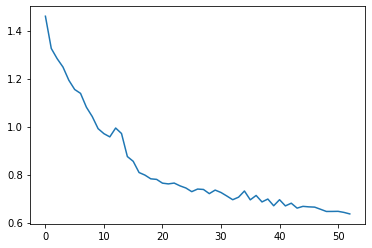

In [33]:
face_convlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'face_convlstm.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(face_X):
    X_train, X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = face_y[train_index], face_y[val_index]
    face_convLSTM = build_convLSTM(face_features, n_length, face_outputs)
    history = train(face_convLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        face_convLSTM.save(face_convlstm_model_path)

In [34]:
face_convlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_convlstm_train_results

{'Accuracy': 0.6638597130775452,
 'ROC/AUC': 0.9144152045249939,
 'Precision': 0.876688289642334,
 'Recall': 0.5432807445526123,
 'F1-score': 0.6478882431983948}

In [35]:
face_convlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_convlstm_val_results

{'Accuracy': 0.3911041855812073,
 'ROC/AUC': 0.6387516379356384,
 'Precision': 0.4425534427165985,
 'Recall': 0.26261681914329527,
 'F1-score': 0.29270278811454775}

#### Train RCNN

In [36]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 2s - loss: 36.1294 - accuracy: 0.3147 - auc_25: 0.5529 - precision_25: 0.3088 - recall_25: 0.3030 - f1_score: 0.2647 - val_loss: 1.5662 - val_accuracy: 0.1852 - val_auc_25: 0.4970 - val_precision_25: 0.4706 - val_recall_25: 0.1481 - val_f1_score: 0.1763 - 2s/epoch - 227ms/step
Epoch 2/100
7/7 - 0s - loss: 12.1875 - accuracy: 0.3357 - auc_25: 0.5753 - precision_25: 0.3364 - recall_25: 0.3357 - f1_score: 0.3232 - val_loss: 1.6745 - val_accuracy: 0.3519 - val_auc_25: 0.5410 - val_precision_25: 0.4483 - val_recall_25: 0.1204 - val_f1_score: 0.2698 - 111ms/epoch - 16ms/step
Epoch 3/100
7/7 - 0s - loss: 8.1853 - accuracy: 0.3287 - auc_25: 0.5667 - precision_25: 0.3278 - recall_25: 0.3240 - f1_score: 0.3102 - val_loss: 1.4340 - val_accuracy: 0.1481 - val_auc_25: 0.4621 - val_precision_25: 0.8000 - val_recall_25: 0.0370 - val_f1_score: 0.1385 - 122ms/epoch - 17ms/step
Epoch 4/100
7/7 - 0s - loss: 2.9589 - accuracy: 0.3800 - auc_25: 0.6435 - precision_25: 0.4047 - recall_25: 0

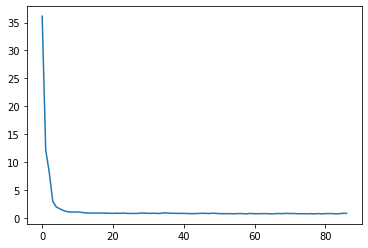

Epoch 1/100
7/7 - 2s - loss: 37.3444 - accuracy: 0.2751 - auc_26: 0.5192 - precision_26: 0.2736 - recall_26: 0.2704 - f1_score: 0.2211 - val_loss: 3.4906 - val_accuracy: 0.1944 - val_auc_26: 0.4556 - val_precision_26: 0.1111 - val_recall_26: 0.0556 - val_f1_score: 0.1735 - 2s/epoch - 227ms/step
Epoch 2/100
7/7 - 0s - loss: 14.8400 - accuracy: 0.3193 - auc_26: 0.5688 - precision_26: 0.3193 - recall_26: 0.3193 - f1_score: 0.2908 - val_loss: 2.1632 - val_accuracy: 0.3426 - val_auc_26: 0.5570 - val_precision_26: 0.3962 - val_recall_26: 0.1944 - val_f1_score: 0.2171 - 135ms/epoch - 19ms/step
Epoch 3/100
7/7 - 0s - loss: 6.9862 - accuracy: 0.3007 - auc_26: 0.5905 - precision_26: 0.3040 - recall_26: 0.2984 - f1_score: 0.2932 - val_loss: 1.4084 - val_accuracy: 0.3056 - val_auc_26: 0.5277 - val_precision_26: 0.5455 - val_recall_26: 0.0556 - val_f1_score: 0.2526 - 129ms/epoch - 18ms/step
Epoch 4/100
7/7 - 0s - loss: 3.7794 - accuracy: 0.3823 - auc_26: 0.6452 - precision_26: 0.3853 - recall_26: 0

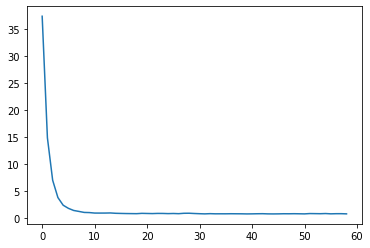

Epoch 1/100
7/7 - 2s - loss: 28.2745 - accuracy: 0.3163 - auc_27: 0.5347 - precision_27: 0.3089 - recall_27: 0.2651 - f1_score: 0.2605 - val_loss: 2.2309 - val_accuracy: 0.3271 - val_auc_27: 0.5645 - val_precision_27: 0.4151 - val_recall_27: 0.2056 - val_f1_score: 0.2475 - 2s/epoch - 225ms/step
Epoch 2/100
7/7 - 0s - loss: 8.5221 - accuracy: 0.3256 - auc_27: 0.5819 - precision_27: 0.3255 - recall_27: 0.3233 - f1_score: 0.2687 - val_loss: 1.7838 - val_accuracy: 0.3178 - val_auc_27: 0.5727 - val_precision_27: 0.3382 - val_recall_27: 0.2150 - val_f1_score: 0.2931 - 138ms/epoch - 20ms/step
Epoch 3/100
7/7 - 0s - loss: 6.4847 - accuracy: 0.3628 - auc_27: 0.6166 - precision_27: 0.3641 - recall_27: 0.3395 - f1_score: 0.2886 - val_loss: 1.9152 - val_accuracy: 0.2617 - val_auc_27: 0.5290 - val_precision_27: 0.2576 - val_recall_27: 0.1589 - val_f1_score: 0.1868 - 116ms/epoch - 17ms/step
Epoch 4/100
7/7 - 0s - loss: 3.7057 - accuracy: 0.3535 - auc_27: 0.6375 - precision_27: 0.3702 - recall_27: 0.

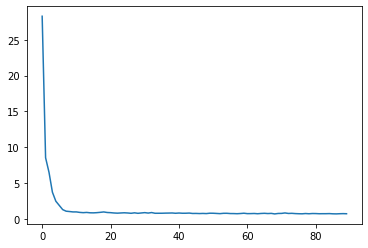

Epoch 1/100
7/7 - 2s - loss: 33.4189 - accuracy: 0.2977 - auc_28: 0.5392 - precision_28: 0.2943 - recall_28: 0.2744 - f1_score: 0.2773 - val_loss: 2.6770 - val_accuracy: 0.3271 - val_auc_28: 0.5600 - val_precision_28: 0.3407 - val_recall_28: 0.2897 - val_f1_score: 0.2061 - 2s/epoch - 220ms/step
Epoch 2/100
7/7 - 0s - loss: 15.6725 - accuracy: 0.3209 - auc_28: 0.5823 - precision_28: 0.3208 - recall_28: 0.3186 - f1_score: 0.2841 - val_loss: 1.6769 - val_accuracy: 0.2336 - val_auc_28: 0.5348 - val_precision_28: 0.4000 - val_recall_28: 0.1308 - val_f1_score: 0.1839 - 127ms/epoch - 18ms/step
Epoch 3/100
7/7 - 0s - loss: 6.7449 - accuracy: 0.3651 - auc_28: 0.6288 - precision_28: 0.3685 - recall_28: 0.3651 - f1_score: 0.3353 - val_loss: 1.8361 - val_accuracy: 0.2150 - val_auc_28: 0.4660 - val_precision_28: 0.2162 - val_recall_28: 0.0748 - val_f1_score: 0.1906 - 111ms/epoch - 16ms/step
Epoch 4/100
7/7 - 0s - loss: 5.0117 - accuracy: 0.4372 - auc_28: 0.6980 - precision_28: 0.4568 - recall_28: 0

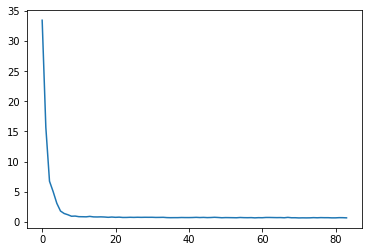

Epoch 1/100
7/7 - 2s - loss: 27.4394 - accuracy: 0.3000 - auc_29: 0.5434 - precision_29: 0.3060 - recall_29: 0.2860 - f1_score: 0.2586 - val_loss: 2.2894 - val_accuracy: 0.3178 - val_auc_29: 0.5382 - val_precision_29: 0.4222 - val_recall_29: 0.1776 - val_f1_score: 0.2587 - 2s/epoch - 221ms/step
Epoch 2/100
7/7 - 0s - loss: 9.3020 - accuracy: 0.3209 - auc_29: 0.5744 - precision_29: 0.3224 - recall_29: 0.3186 - f1_score: 0.2893 - val_loss: 1.4961 - val_accuracy: 0.3084 - val_auc_29: 0.5551 - val_precision_29: 0.5000 - val_recall_29: 0.1495 - val_f1_score: 0.2458 - 127ms/epoch - 18ms/step
Epoch 3/100
7/7 - 0s - loss: 5.1184 - accuracy: 0.3860 - auc_29: 0.6284 - precision_29: 0.3894 - recall_29: 0.3767 - f1_score: 0.3254 - val_loss: 1.3275 - val_accuracy: 0.2617 - val_auc_29: 0.6016 - val_precision_29: 0.4286 - val_recall_29: 0.0280 - val_f1_score: 0.2573 - 128ms/epoch - 18ms/step
Epoch 4/100
7/7 - 0s - loss: 3.2288 - accuracy: 0.3698 - auc_29: 0.6480 - precision_29: 0.3708 - recall_29: 0.

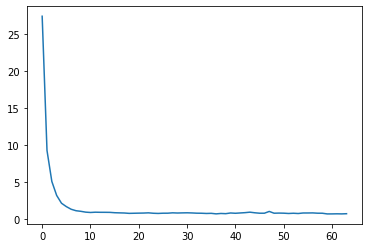

In [37]:
face_rcnn_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'face_rcnn.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(face_X):
    X_train, X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = face_y[train_index], face_y[val_index]
    face_rcnn = build_RCNN(face_features, n_length, face_outputs)
    history = train(face_rcnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        face_rcnn.save(face_rcnn_model_path)

In [38]:
face_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_rcnn_train_results

{'Accuracy': 0.654079258441925,
 'ROC/AUC': 0.8951334595680237,
 'Precision': 0.872654378414154,
 'Recall': 0.5330373525619507,
 'F1-score': 0.6429026603698731}

In [39]:
face_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_rcnn_val_results

{'Accuracy': 0.3705780565738678,
 'ROC/AUC': 0.631205940246582,
 'Precision': 0.45377307534217837,
 'Recall': 0.22352024614810945,
 'F1-score': 0.28137395679950716}

### 1.3 Head modality (pose)

#### About the data

In [81]:
head_X_train, head_X_test, head_y_train, head_y_test, head_feature_names, c = load_dataset('processed', 'pose')
head_X = head_X_train.copy()
head_y = head_y_train.copy()

print(head_X_train.shape, head_y_train.shape)
print(head_X_test.shape, head_y_test.shape)

n_length, head_features, head_outputs = head_X_train.shape[2], head_X_train.shape[-1], head_y_train.shape[1]

(537, 1, 350, 6) (537, 4)
(60, 1, 350, 6) (60, 4)


#### Train CNN+LSTM

In [41]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 6s - loss: 1.3600 - accuracy: 0.3753 - auc_30: 0.5941 - precision_30: 0.3594 - recall_30: 0.0536 - f1_score: 0.2001 - val_loss: 1.3237 - val_accuracy: 0.3796 - val_auc_30: 0.6432 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00 - val_f1_score: 0.1376 - 6s/epoch - 870ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3362 - accuracy: 0.4009 - auc_30: 0.6197 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00 - f1_score: 0.1431 - val_loss: 1.3385 - val_accuracy: 0.3796 - val_auc_30: 0.6411 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00 - val_f1_score: 0.1376 - 170ms/epoch - 24ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3334 - accuracy: 0.4009 - auc_30: 0.6161 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00 - f1_score: 0.1431 - val_loss: 1.3038 - val_accuracy: 0.3796 - val_auc_30: 0.6645 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00 - val_f1_score: 0.1376 - 212ms/epoch - 30ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3316 - accuracy: 0.4009 - auc_30: 0.6115

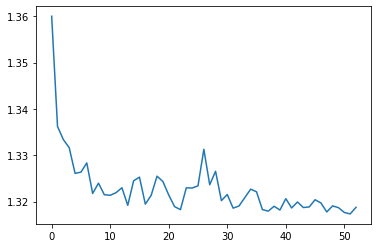

Epoch 1/100
7/7 - 5s - loss: 1.3604 - accuracy: 0.3170 - auc_31: 0.6005 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - f1_score: 0.1858 - val_loss: 1.3458 - val_accuracy: 0.3796 - val_auc_31: 0.6004 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00 - val_f1_score: 0.1376 - 5s/epoch - 782ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3210 - accuracy: 0.4009 - auc_31: 0.6310 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - f1_score: 0.1431 - val_loss: 1.4032 - val_accuracy: 0.3796 - val_auc_31: 0.5809 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00 - val_f1_score: 0.1376 - 168ms/epoch - 24ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3240 - accuracy: 0.4009 - auc_31: 0.6378 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - f1_score: 0.1431 - val_loss: 1.3739 - val_accuracy: 0.3796 - val_auc_31: 0.5833 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00 - val_f1_score: 0.1376 - 171ms/epoch - 24ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3088 - accuracy: 0.4009 - auc_31

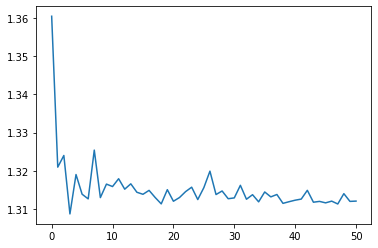

Epoch 1/100
7/7 - 6s - loss: 1.3519 - accuracy: 0.3140 - auc_32: 0.5944 - precision_32: 0.4531 - recall_32: 0.0674 - f1_score: 0.2244 - val_loss: 1.3541 - val_accuracy: 0.3832 - val_auc_32: 0.6112 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00 - val_f1_score: 0.1385 - 6s/epoch - 834ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3385 - accuracy: 0.4000 - auc_32: 0.6186 - precision_32: 0.3984 - recall_32: 0.1186 - f1_score: 0.1429 - val_loss: 1.3538 - val_accuracy: 0.3832 - val_auc_32: 0.6099 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00 - val_f1_score: 0.1385 - 210ms/epoch - 30ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3475 - accuracy: 0.3558 - auc_32: 0.6094 - precision_32: 0.0000e+00 - recall_32: 0.0000e+00 - f1_score: 0.1613 - val_loss: 1.3743 - val_accuracy: 0.3832 - val_auc_32: 0.6087 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00 - val_f1_score: 0.1385 - 168ms/epoch - 24ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3222 - accuracy: 0.4000 - auc_32: 0.6314 - preci

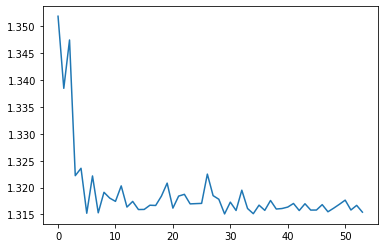

Epoch 1/100
7/7 - 6s - loss: 1.3675 - accuracy: 0.3698 - auc_33: 0.5822 - precision_33: 0.0000e+00 - recall_33: 0.0000e+00 - f1_score: 0.1866 - val_loss: 1.3228 - val_accuracy: 0.3925 - val_auc_33: 0.6412 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00 - val_f1_score: 0.1409 - 6s/epoch - 789ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3286 - accuracy: 0.3977 - auc_33: 0.6275 - precision_33: 0.0000e+00 - recall_33: 0.0000e+00 - f1_score: 0.1423 - val_loss: 1.3348 - val_accuracy: 0.3925 - val_auc_33: 0.6146 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00 - val_f1_score: 0.1409 - 173ms/epoch - 25ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3359 - accuracy: 0.4000 - auc_33: 0.6138 - precision_33: 0.0000e+00 - recall_33: 0.0000e+00 - f1_score: 0.1530 - val_loss: 1.3271 - val_accuracy: 0.3832 - val_auc_33: 0.6379 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00 - val_f1_score: 0.1653 - 165ms/epoch - 24ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3302 - accuracy: 0.4140 - auc_33

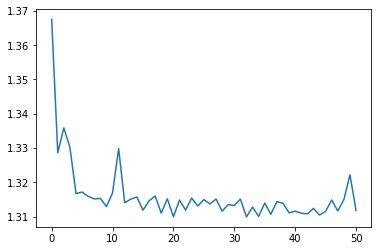

Epoch 1/100
7/7 - 6s - loss: 1.3787 - accuracy: 0.3302 - auc_34: 0.5866 - precision_34: 0.4118 - recall_34: 0.0326 - f1_score: 0.1987 - val_loss: 1.3073 - val_accuracy: 0.4486 - val_auc_34: 0.6143 - val_precision_34: 0.0000e+00 - val_recall_34: 0.0000e+00 - val_f1_score: 0.1548 - 6s/epoch - 863ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3516 - accuracy: 0.3837 - auc_34: 0.6035 - precision_34: 0.0000e+00 - recall_34: 0.0000e+00 - f1_score: 0.1387 - val_loss: 1.2785 - val_accuracy: 0.4486 - val_auc_34: 0.6619 - val_precision_34: 0.0000e+00 - val_recall_34: 0.0000e+00 - val_f1_score: 0.1548 - 217ms/epoch - 31ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3465 - accuracy: 0.3814 - auc_34: 0.6106 - precision_34: 0.0000e+00 - recall_34: 0.0000e+00 - f1_score: 0.1521 - val_loss: 1.3141 - val_accuracy: 0.4579 - val_auc_34: 0.6462 - val_precision_34: 0.0000e+00 - val_recall_34: 0.0000e+00 - val_f1_score: 0.1870 - 169ms/epoch - 24ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3466 - accuracy: 0.3791 - auc_34: 0.6030

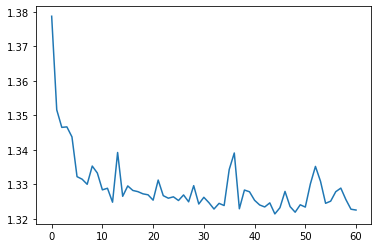

In [42]:
head_cnnlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'head_cnnlstm.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(head_X):
    X_train, X_val = head_X[train_index], head_X[val_index]
    y_train, y_val = head_y[train_index], head_y[val_index]
    head_cnnlstm = build_CNNLSTM(head_features, n_length, head_outputs)
    history = train(head_cnnlstm, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        head_cnnlstm.save(head_cnnlstm_model_path)

In [43]:
head_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
head_cnnlstm_train_results

{'Accuracy': 0.40502737164497377,
 'ROC/AUC': 0.6329341888427734,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1-score': 0.1698608934879303}

In [44]:
head_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
head_cnnlstm_val_results

{'Accuracy': 0.40226722359657285,
 'ROC/AUC': 0.6170607566833496,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1-score': 0.1663474202156067}

#### Train ConvLSTM

In [45]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 9s - loss: 2.9798 - accuracy: 0.3357 - auc_35: 0.5810 - precision_35: 0.3810 - recall_35: 0.2797 - f1_score: 0.1937 - val_loss: 2.2848 - val_accuracy: 0.0833 - val_auc_35: 0.3601 - val_precision_35: 0.0833 - val_recall_35: 0.0833 - val_f1_score: 0.0385 - 9s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.6995 - accuracy: 0.1958 - auc_35: 0.4705 - precision_35: 0.1968 - recall_35: 0.1445 - f1_score: 0.1437 - val_loss: 1.3099 - val_accuracy: 0.3796 - val_auc_35: 0.6697 - val_precision_35: 0.4082 - val_recall_35: 0.3704 - val_f1_score: 0.1376 - 758ms/epoch - 108ms/step
Epoch 3/100
7/7 - 1s - loss: 1.4717 - accuracy: 0.3986 - auc_35: 0.6236 - precision_35: 0.3913 - recall_35: 0.2727 - f1_score: 0.1432 - val_loss: 1.4899 - val_accuracy: 0.4074 - val_auc_35: 0.5682 - val_precision_35: 0.0000e+00 - val_recall_35: 0.0000e+00 - val_f1_score: 0.2033 - 728ms/epoch - 104ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3836 - accuracy: 0.4056 - auc_35: 0.5942 - precision_35: 0.0000e+00 - rec

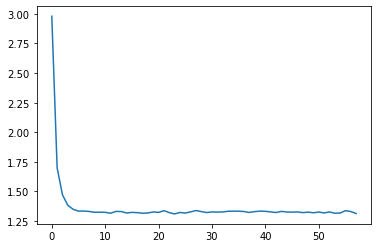

Epoch 1/100
7/7 - 10s - loss: 2.6443 - accuracy: 0.2751 - auc_36: 0.5696 - precision_36: 0.2808 - recall_36: 0.2075 - f1_score: 0.2210 - val_loss: 1.9766 - val_accuracy: 0.3796 - val_auc_36: 0.5748 - val_precision_36: 0.3796 - val_recall_36: 0.3796 - val_f1_score: 0.1376 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.5351 - accuracy: 0.3333 - auc_36: 0.5799 - precision_36: 0.3906 - recall_36: 0.2331 - f1_score: 0.1675 - val_loss: 1.3893 - val_accuracy: 0.2037 - val_auc_36: 0.5075 - val_precision_36: 0.0000e+00 - val_recall_36: 0.0000e+00 - val_f1_score: 0.0846 - 777ms/epoch - 111ms/step
Epoch 3/100
7/7 - 1s - loss: 1.3688 - accuracy: 0.3590 - auc_36: 0.6153 - precision_36: 0.3556 - recall_36: 0.0373 - f1_score: 0.1628 - val_loss: 1.5308 - val_accuracy: 0.3796 - val_auc_36: 0.5943 - val_precision_36: 0.3796 - val_recall_36: 0.3796 - val_f1_score: 0.1376 - 725ms/epoch - 104ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3553 - accuracy: 0.4009 - auc_36: 0.6341 - precision_36: 0.3906 - recal

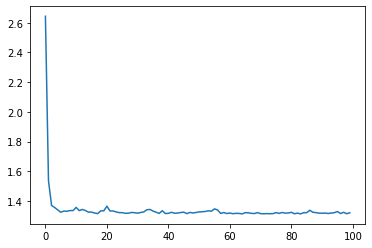

Epoch 1/100
7/7 - 10s - loss: 3.1443 - accuracy: 0.2698 - auc_37: 0.5797 - precision_37: 0.2760 - recall_37: 0.2349 - f1_score: 0.1958 - val_loss: 1.3958 - val_accuracy: 0.1869 - val_auc_37: 0.5250 - val_precision_37: 0.0000e+00 - val_recall_37: 0.0000e+00 - val_f1_score: 0.0965 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.7359 - accuracy: 0.2884 - auc_37: 0.5378 - precision_37: 0.3636 - recall_37: 0.0930 - f1_score: 0.1775 - val_loss: 1.6998 - val_accuracy: 0.3832 - val_auc_37: 0.5701 - val_precision_37: 0.3832 - val_recall_37: 0.3832 - val_f1_score: 0.1385 - 728ms/epoch - 104ms/step
Epoch 3/100
7/7 - 1s - loss: 1.3910 - accuracy: 0.3884 - auc_37: 0.6275 - precision_37: 0.4115 - recall_37: 0.1837 - f1_score: 0.2150 - val_loss: 1.5300 - val_accuracy: 0.2430 - val_auc_37: 0.5607 - val_precision_37: 0.2430 - val_recall_37: 0.2430 - val_f1_score: 0.0977 - 745ms/epoch - 106ms/step
Epoch 4/100
7/7 - 1s - loss: 1.4047 - accuracy: 0.3209 - auc_37: 0.5978 - precision_37: 0.2812 - recal

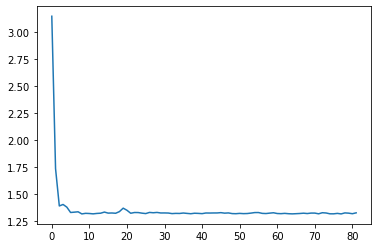

Epoch 1/100
7/7 - 9s - loss: 2.8741 - accuracy: 0.3512 - auc_38: 0.5933 - precision_38: 0.3644 - recall_38: 0.2907 - f1_score: 0.2836 - val_loss: 1.9044 - val_accuracy: 0.3832 - val_auc_38: 0.6405 - val_precision_38: 0.3725 - val_recall_38: 0.3551 - val_f1_score: 0.1653 - 9s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.6474 - accuracy: 0.2512 - auc_38: 0.5412 - precision_38: 0.4568 - recall_38: 0.0860 - f1_score: 0.2245 - val_loss: 1.5700 - val_accuracy: 0.1402 - val_auc_38: 0.4610 - val_precision_38: 0.1250 - val_recall_38: 0.0093 - val_f1_score: 0.0615 - 768ms/epoch - 110ms/step
Epoch 3/100
7/7 - 1s - loss: 1.4306 - accuracy: 0.3581 - auc_38: 0.5880 - precision_38: 0.3529 - recall_38: 0.1116 - f1_score: 0.2190 - val_loss: 1.3886 - val_accuracy: 0.2710 - val_auc_38: 0.5983 - val_precision_38: 0.3333 - val_recall_38: 0.0280 - val_f1_score: 0.1247 - 761ms/epoch - 109ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3751 - accuracy: 0.3884 - auc_38: 0.6245 - precision_38: 0.3333 - recall_38: 0.00

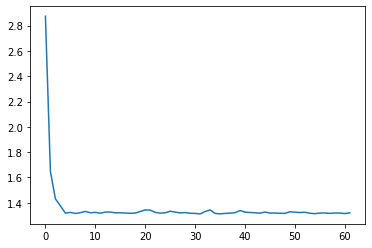

Epoch 1/100
7/7 - 10s - loss: 3.1557 - accuracy: 0.3442 - auc_39: 0.5831 - precision_39: 0.3248 - recall_39: 0.2372 - f1_score: 0.2182 - val_loss: 1.5645 - val_accuracy: 0.2617 - val_auc_39: 0.6200 - val_precision_39: 0.2617 - val_recall_39: 0.2617 - val_f1_score: 0.1037 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.8632 - accuracy: 0.3442 - auc_39: 0.5507 - precision_39: 0.2555 - recall_39: 0.0814 - f1_score: 0.2008 - val_loss: 1.4900 - val_accuracy: 0.4486 - val_auc_39: 0.6093 - val_precision_39: 0.0000e+00 - val_recall_39: 0.0000e+00 - val_f1_score: 0.1548 - 769ms/epoch - 110ms/step
Epoch 3/100
7/7 - 1s - loss: 1.4725 - accuracy: 0.2744 - auc_39: 0.5308 - precision_39: 0.0000e+00 - recall_39: 0.0000e+00 - f1_score: 0.2040 - val_loss: 1.3571 - val_accuracy: 0.4206 - val_auc_39: 0.6452 - val_precision_39: 0.0000e+00 - val_recall_39: 0.0000e+00 - val_f1_score: 0.1520 - 767ms/epoch - 110ms/step
Epoch 4/100
7/7 - 1s - loss: 1.4229 - accuracy: 0.3860 - auc_39: 0.6090 - precision_39

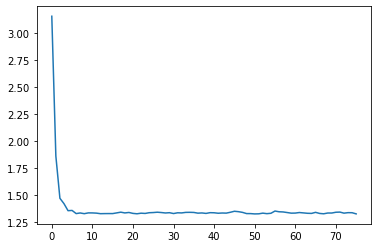

In [46]:
head_convLSTM_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'head_convLSTM.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(head_X):
    X_train, X_val = head_X[train_index], head_X[val_index]
    y_train, y_val = head_y[train_index], head_y[val_index]
    head_convLSTM = build_convLSTM(head_features, n_length, head_outputs)
    history = train(head_convLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        head_convLSTM.save(head_convLSTM_model_path)

In [47]:
head_convLSTM_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
head_convLSTM_train_results

{'Accuracy': 0.40456334352493284,
 'ROC/AUC': 0.6283843517303467,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1-score': 0.16931918263435364}

In [48]:
head_convLSTM_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
head_convLSTM_val_results

{'Accuracy': 0.40039806365966796,
 'ROC/AUC': 0.6256081104278565,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1-score': 0.16570831537246705}

#### Train RCNN

In [49]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 2s - loss: 20.8992 - accuracy: 0.3240 - auc_40: 0.5359 - precision_40: 0.3037 - recall_40: 0.2704 - f1_score: 0.2514 - val_loss: 38.5284 - val_accuracy: 0.0833 - val_auc_40: 0.3755 - val_precision_40: 0.0000e+00 - val_recall_40: 0.0000e+00 - val_f1_score: 0.0385 - 2s/epoch - 224ms/step
Epoch 2/100
7/7 - 0s - loss: 8.3699 - accuracy: 0.2821 - auc_40: 0.5197 - precision_40: 0.2821 - recall_40: 0.2821 - f1_score: 0.2446 - val_loss: 25.2215 - val_accuracy: 0.2593 - val_auc_40: 0.4861 - val_precision_40: 0.3077 - val_recall_40: 0.0741 - val_f1_score: 0.1362 - 130ms/epoch - 19ms/step
Epoch 3/100
7/7 - 0s - loss: 5.2090 - accuracy: 0.2914 - auc_40: 0.5596 - precision_40: 0.3180 - recall_40: 0.2424 - f1_score: 0.2340 - val_loss: 2.8024 - val_accuracy: 0.2130 - val_auc_40: 0.5172 - val_precision_40: 0.1429 - val_recall_40: 0.0278 - val_f1_score: 0.1102 - 126ms/epoch - 18ms/step
Epoch 4/100
7/7 - 0s - loss: 2.7865 - accuracy: 0.3427 - auc_40: 0.5779 - precision_40: 0.3477 - rec

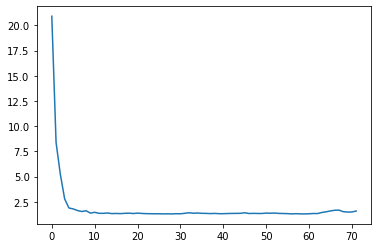

Epoch 1/100
7/7 - 2s - loss: 23.9173 - accuracy: 0.2914 - auc_41: 0.5115 - precision_41: 0.2850 - recall_41: 0.2517 - f1_score: 0.2652 - val_loss: 34.7492 - val_accuracy: 0.3333 - val_auc_41: 0.5163 - val_precision_41: 0.0870 - val_recall_41: 0.0185 - val_f1_score: 0.1434 - 2s/epoch - 224ms/step
Epoch 2/100
7/7 - 0s - loss: 7.5906 - accuracy: 0.3100 - auc_41: 0.5971 - precision_41: 0.3010 - recall_41: 0.2681 - f1_score: 0.2593 - val_loss: 8.0271 - val_accuracy: 0.4167 - val_auc_41: 0.5986 - val_precision_41: 0.4783 - val_recall_41: 0.1019 - val_f1_score: 0.2217 - 124ms/epoch - 18ms/step
Epoch 3/100
7/7 - 0s - loss: 4.7637 - accuracy: 0.2890 - auc_41: 0.5675 - precision_41: 0.3080 - recall_41: 0.1795 - f1_score: 0.2528 - val_loss: 3.2854 - val_accuracy: 0.3611 - val_auc_41: 0.5677 - val_precision_41: 0.2174 - val_recall_41: 0.0463 - val_f1_score: 0.2081 - 132ms/epoch - 19ms/step
Epoch 4/100
7/7 - 0s - loss: 3.1691 - accuracy: 0.3636 - auc_41: 0.5940 - precision_41: 0.3906 - recall_41: 0

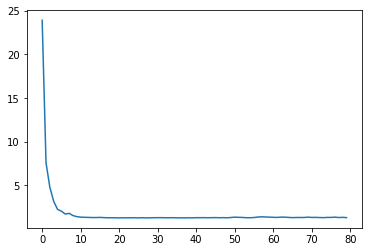

Epoch 1/100
7/7 - 2s - loss: 30.0376 - accuracy: 0.2721 - auc_42: 0.5328 - precision_42: 0.2876 - recall_42: 0.2581 - f1_score: 0.2208 - val_loss: 62.6764 - val_accuracy: 0.3458 - val_auc_42: 0.5498 - val_precision_42: 0.3458 - val_recall_42: 0.3458 - val_f1_score: 0.1609 - 2s/epoch - 221ms/step
Epoch 2/100
7/7 - 0s - loss: 12.8559 - accuracy: 0.2674 - auc_42: 0.5603 - precision_42: 0.2749 - recall_42: 0.2442 - f1_score: 0.2610 - val_loss: 16.4556 - val_accuracy: 0.3738 - val_auc_42: 0.5607 - val_precision_42: 0.3738 - val_recall_42: 0.3738 - val_f1_score: 0.1977 - 126ms/epoch - 18ms/step
Epoch 3/100
7/7 - 0s - loss: 9.7500 - accuracy: 0.2884 - auc_42: 0.5325 - precision_42: 0.3138 - recall_42: 0.2744 - f1_score: 0.2304 - val_loss: 8.6849 - val_accuracy: 0.2243 - val_auc_42: 0.5297 - val_precision_42: 0.2593 - val_recall_42: 0.0654 - val_f1_score: 0.1647 - 128ms/epoch - 18ms/step
Epoch 4/100
7/7 - 0s - loss: 5.3218 - accuracy: 0.3535 - auc_42: 0.5836 - precision_42: 0.3632 - recall_42:

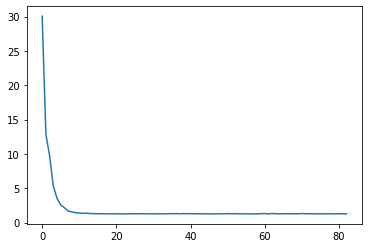

Epoch 1/100
7/7 - 2s - loss: 20.6637 - accuracy: 0.2930 - auc_43: 0.5399 - precision_43: 0.3117 - recall_43: 0.2791 - f1_score: 0.2620 - val_loss: 62.6804 - val_accuracy: 0.2804 - val_auc_43: 0.5254 - val_precision_43: 0.2424 - val_recall_43: 0.0748 - val_f1_score: 0.1993 - 2s/epoch - 222ms/step
Epoch 2/100
7/7 - 0s - loss: 11.4506 - accuracy: 0.2953 - auc_43: 0.5441 - precision_43: 0.2953 - recall_43: 0.2953 - f1_score: 0.2531 - val_loss: 33.0775 - val_accuracy: 0.2523 - val_auc_43: 0.5033 - val_precision_43: 0.2523 - val_recall_43: 0.2523 - val_f1_score: 0.1580 - 121ms/epoch - 17ms/step
Epoch 3/100
7/7 - 0s - loss: 7.8701 - accuracy: 0.2907 - auc_43: 0.5409 - precision_43: 0.2921 - recall_43: 0.2907 - f1_score: 0.2051 - val_loss: 14.3990 - val_accuracy: 0.1589 - val_auc_43: 0.4213 - val_precision_43: 0.2424 - val_recall_43: 0.0748 - val_f1_score: 0.1067 - 126ms/epoch - 18ms/step
Epoch 4/100
7/7 - 0s - loss: 5.0631 - accuracy: 0.2302 - auc_43: 0.5188 - precision_43: 0.2581 - recall_43

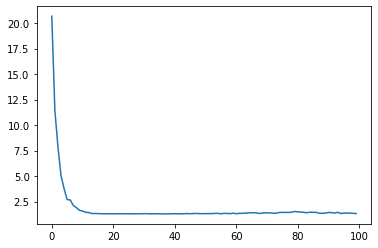

Epoch 1/100
7/7 - 2s - loss: 27.7053 - accuracy: 0.3093 - auc_44: 0.5518 - precision_44: 0.3238 - recall_44: 0.2884 - f1_score: 0.2638 - val_loss: 36.2296 - val_accuracy: 0.4579 - val_auc_44: 0.6392 - val_precision_44: 0.5200 - val_recall_44: 0.1215 - val_f1_score: 0.1870 - 2s/epoch - 223ms/step
Epoch 2/100
7/7 - 0s - loss: 11.7972 - accuracy: 0.2791 - auc_44: 0.5116 - precision_44: 0.2791 - recall_44: 0.2791 - f1_score: 0.2619 - val_loss: 12.2371 - val_accuracy: 0.1028 - val_auc_44: 0.4435 - val_precision_44: 0.1028 - val_recall_44: 0.1028 - val_f1_score: 0.0482 - 124ms/epoch - 18ms/step
Epoch 3/100
7/7 - 0s - loss: 7.9950 - accuracy: 0.2837 - auc_44: 0.5184 - precision_44: 0.2824 - recall_44: 0.2535 - f1_score: 0.2361 - val_loss: 12.9558 - val_accuracy: 0.2617 - val_auc_44: 0.4360 - val_precision_44: 0.2400 - val_recall_44: 0.0561 - val_f1_score: 0.1037 - 113ms/epoch - 16ms/step
Epoch 4/100
7/7 - 0s - loss: 5.3739 - accuracy: 0.2605 - auc_44: 0.5103 - precision_44: 0.2543 - recall_44

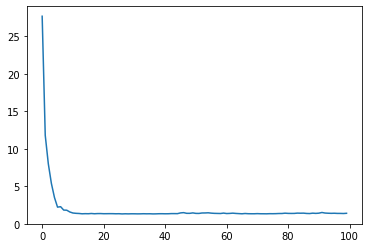

In [50]:
head_rcnn_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'head_rcnn.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(head_X):
    X_train, X_val = head_X[train_index], head_X[val_index]
    y_train, y_val = head_y[train_index], head_y[val_index]
    head_rcnn = build_RCNN(head_features, n_length, head_outputs)
    history = train(head_rcnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        head_rcnn.save(head_rcnn_model_path)

In [51]:
head_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
head_rcnn_train_results

{'Accuracy': 0.41433837413787844,
 'ROC/AUC': 0.6322564005851745,
 'Precision': 0.4442014515399933,
 'Recall': 0.07032688334584236,
 'F1-score': 0.23615576326847076}

In [52]:
head_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
head_rcnn_val_results

{'Accuracy': 0.38926964402198794,
 'ROC/AUC': 0.5934197306632996,
 'Precision': 0.2626984164118767,
 'Recall': 0.027933540195226668,
 'F1-score': 0.19444373846054078}

## 2. Early Fusion - Fusion is performed at feature level

Early fusion concatenates features at the input level, then all the work is on the classifier. 

My initial assumption is that perhaps early fusion is not the best idea because the face modality is missing about half the times (OpenFace could not capture facial action units from the videos), which makes the dataset smaller. 
I did not replace the missing facial values because I thought null values will bring no benefit (I assume?) and adding for example zero would mean the absence of action units which I'm afraid might actually "trick" the model in the case where a person has pain and the facial modality was not available because of technical issues, not because of an actual lack of pain.

### About the data

In [80]:
early_X_train, early_X_test, early_y_train, early_y_test = load_earlyfusion_dataset('processed')
early_X = early_X_train.copy()
early_y = early_y_train.copy()

print(early_X_train.shape, early_y_train.shape)
print(early_X_test.shape, early_y_test.shape)

n_length, early_features, early_outputs = early_X_train.shape[2], early_X_train.shape[-1], early_y_train.shape[1]

(537, 1, 350, 54) (537, 4)
(60, 1, 350, 54) (60, 4)


In [54]:
umild, lmoderate, lmild, umoderate = np.sum(early_y, axis=0)
total = umild + lmoderate + lmild + umoderate

weight_for_0 = (1 / umild) * (total / 2.0)
weight_for_1 = (1 / lmoderate) * (total / 2.0)
weight_for_2 = (1 / lmild) * (total / 2.0)
weight_for_3 = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

### Train CNN+LSTM (with early fusion)

In [55]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 6s - loss: 1.3594 - accuracy: 0.3613 - auc_45: 0.6015 - precision_45: 0.4355 - recall_45: 0.0629 - f1_score: 0.2178 - val_loss: 1.4168 - val_accuracy: 0.3796 - val_auc_45: 0.5370 - val_precision_45: 0.0000e+00 - val_recall_45: 0.0000e+00 - val_f1_score: 0.1376 - 6s/epoch - 788ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3399 - accuracy: 0.4009 - auc_45: 0.6159 - precision_45: 0.0000e+00 - recall_45: 0.0000e+00 - f1_score: 0.1431 - val_loss: 1.3064 - val_accuracy: 0.3796 - val_auc_45: 0.6358 - val_precision_45: 0.0000e+00 - val_recall_45: 0.0000e+00 - val_f1_score: 0.1376 - 226ms/epoch - 32ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3311 - accuracy: 0.4009 - auc_45: 0.6238 - precision_45: 0.0000e+00 - recall_45: 0.0000e+00 - f1_score: 0.1431 - val_loss: 1.3400 - val_accuracy: 0.3796 - val_auc_45: 0.6358 - val_precision_45: 0.0000e+00 - val_recall_45: 0.0000e+00 - val_f1_score: 0.1376 - 180ms/epoch - 26ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3356 - accuracy: 0.4009 - auc_45: 0.6020

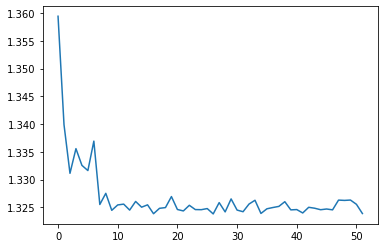

Epoch 1/100
7/7 - 6s - loss: 1.3626 - accuracy: 0.3869 - auc_46: 0.6060 - precision_46: 0.0000e+00 - recall_46: 0.0000e+00 - f1_score: 0.1584 - val_loss: 1.3690 - val_accuracy: 0.3796 - val_auc_46: 0.5694 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00 - val_f1_score: 0.1376 - 6s/epoch - 787ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3271 - accuracy: 0.4009 - auc_46: 0.6300 - precision_46: 0.0000e+00 - recall_46: 0.0000e+00 - f1_score: 0.1431 - val_loss: 1.3803 - val_accuracy: 0.3796 - val_auc_46: 0.5875 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00 - val_f1_score: 0.1376 - 179ms/epoch - 26ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3166 - accuracy: 0.4009 - auc_46: 0.6305 - precision_46: 0.0000e+00 - recall_46: 0.0000e+00 - f1_score: 0.1431 - val_loss: 1.3663 - val_accuracy: 0.3796 - val_auc_46: 0.5827 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00 - val_f1_score: 0.1376 - 227ms/epoch - 32ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3147 - accuracy: 0.4009 - auc_46

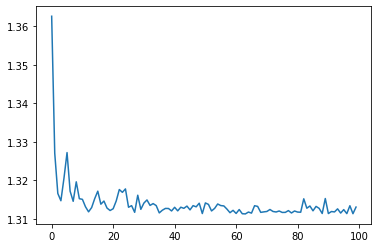

Epoch 1/100
7/7 - 6s - loss: 1.3631 - accuracy: 0.3651 - auc_47: 0.6111 - precision_47: 0.0000e+00 - recall_47: 0.0000e+00 - f1_score: 0.2266 - val_loss: 1.3866 - val_accuracy: 0.2430 - val_auc_47: 0.5559 - val_precision_47: 0.0000e+00 - val_recall_47: 0.0000e+00 - val_f1_score: 0.0977 - 6s/epoch - 789ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3566 - accuracy: 0.3256 - auc_47: 0.5981 - precision_47: 0.0000e+00 - recall_47: 0.0000e+00 - f1_score: 0.1776 - val_loss: 1.3639 - val_accuracy: 0.3832 - val_auc_47: 0.5895 - val_precision_47: 0.0000e+00 - val_recall_47: 0.0000e+00 - val_f1_score: 0.1385 - 225ms/epoch - 32ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3114 - accuracy: 0.4000 - auc_47: 0.6468 - precision_47: 0.0000e+00 - recall_47: 0.0000e+00 - f1_score: 0.1429 - val_loss: 1.3621 - val_accuracy: 0.3832 - val_auc_47: 0.5974 - val_precision_47: 0.0000e+00 - val_recall_47: 0.0000e+00 - val_f1_score: 0.1385 - 226ms/epoch - 32ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3187 - accuracy: 0.4023 - auc_47

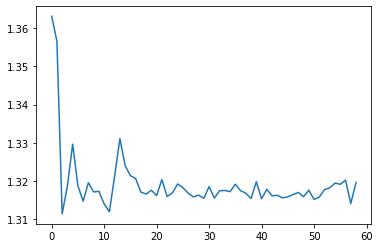

Epoch 1/100
7/7 - 6s - loss: 1.3502 - accuracy: 0.3837 - auc_48: 0.6142 - precision_48: 0.4248 - recall_48: 0.1116 - f1_score: 0.2150 - val_loss: 1.3173 - val_accuracy: 0.3925 - val_auc_48: 0.6396 - val_precision_48: 0.0000e+00 - val_recall_48: 0.0000e+00 - val_f1_score: 0.1409 - 6s/epoch - 877ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3371 - accuracy: 0.3977 - auc_48: 0.6055 - precision_48: 0.0000e+00 - recall_48: 0.0000e+00 - f1_score: 0.1423 - val_loss: 1.3269 - val_accuracy: 0.3925 - val_auc_48: 0.6221 - val_precision_48: 0.0000e+00 - val_recall_48: 0.0000e+00 - val_f1_score: 0.1409 - 184ms/epoch - 26ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3329 - accuracy: 0.3977 - auc_48: 0.6181 - precision_48: 0.0000e+00 - recall_48: 0.0000e+00 - f1_score: 0.1423 - val_loss: 1.3157 - val_accuracy: 0.3925 - val_auc_48: 0.6382 - val_precision_48: 0.0000e+00 - val_recall_48: 0.0000e+00 - val_f1_score: 0.1409 - 230ms/epoch - 33ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3291 - accuracy: 0.3977 - auc_48: 0.6171

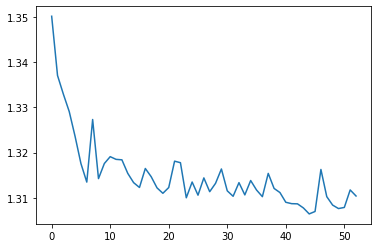

Epoch 1/100
7/7 - 6s - loss: 1.3723 - accuracy: 0.3651 - auc_49: 0.5935 - precision_49: 0.0000e+00 - recall_49: 0.0000e+00 - f1_score: 0.1860 - val_loss: 1.3027 - val_accuracy: 0.4486 - val_auc_49: 0.6821 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00 - val_f1_score: 0.1548 - 6s/epoch - 789ms/step
Epoch 2/100
7/7 - 0s - loss: 1.3419 - accuracy: 0.3791 - auc_49: 0.6124 - precision_49: 0.0000e+00 - recall_49: 0.0000e+00 - f1_score: 0.1374 - val_loss: 1.2842 - val_accuracy: 0.4486 - val_auc_49: 0.6640 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00 - val_f1_score: 0.1548 - 229ms/epoch - 33ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3364 - accuracy: 0.3837 - auc_49: 0.6102 - precision_49: 0.0000e+00 - recall_49: 0.0000e+00 - f1_score: 0.1387 - val_loss: 1.2929 - val_accuracy: 0.4486 - val_auc_49: 0.6725 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00 - val_f1_score: 0.1548 - 182ms/epoch - 26ms/step
Epoch 4/100
7/7 - 0s - loss: 1.3414 - accuracy: 0.3837 - auc_49

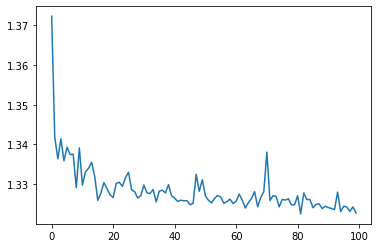

In [56]:
early_cnnlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'early_cnnlstm.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(early_X):
    X_train, X_val = early_X[train_index], early_X[val_index]
    y_train, y_val = early_y[train_index], early_y[val_index]
    early_cnnlstm = build_CNNLSTM(early_features, n_length, early_outputs)
    history = train(early_cnnlstm, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        early_cnnlstm.save(early_cnnlstm_model_path)

In [57]:
early_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_cnnlstm_train_results

{'Accuracy': 0.4040938913822174,
 'ROC/AUC': 0.6275437474250793,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1-score': 0.1647810608148575}

In [58]:
early_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_cnnlstm_val_results

{'Accuracy': 0.3967116713523865,
 'ROC/AUC': 0.6188904881477356,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1-score': 0.15359316468238832}

### Train ConvLSTM (with early fusion)

In [59]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 10s - loss: 3.5530 - accuracy: 0.2541 - auc_50: 0.5409 - precision_50: 0.2767 - recall_50: 0.2051 - f1_score: 0.2154 - val_loss: 1.7089 - val_accuracy: 0.3796 - val_auc_50: 0.6649 - val_precision_50: 0.3796 - val_recall_50: 0.3796 - val_f1_score: 0.1376 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.7478 - accuracy: 0.3800 - auc_50: 0.6078 - precision_50: 0.3853 - recall_50: 0.2937 - f1_score: 0.1856 - val_loss: 1.6548 - val_accuracy: 0.0833 - val_auc_50: 0.4185 - val_precision_50: 0.0000e+00 - val_recall_50: 0.0000e+00 - val_f1_score: 0.0385 - 778ms/epoch - 111ms/step
Epoch 3/100
7/7 - 1s - loss: 1.4342 - accuracy: 0.2821 - auc_50: 0.5457 - precision_50: 0.4545 - recall_50: 0.0583 - f1_score: 0.2226 - val_loss: 1.3346 - val_accuracy: 0.3796 - val_auc_50: 0.6642 - val_precision_50: 0.3900 - val_recall_50: 0.3611 - val_f1_score: 0.1546 - 757ms/epoch - 108ms/step
Epoch 4/100
7/7 - 1s - loss: 1.4064 - accuracy: 0.4079 - auc_50: 0.6097 - precision_50: 0.4167 - recal

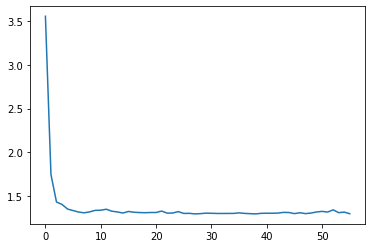

Epoch 1/100
7/7 - 9s - loss: 2.7825 - accuracy: 0.2914 - auc_51: 0.5706 - precision_51: 0.3636 - recall_51: 0.1305 - f1_score: 0.2462 - val_loss: 2.0438 - val_accuracy: 0.1944 - val_auc_51: 0.4684 - val_precision_51: 0.1944 - val_recall_51: 0.1944 - val_f1_score: 0.0814 - 9s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.6522 - accuracy: 0.3427 - auc_51: 0.5367 - precision_51: 0.3122 - recall_51: 0.1725 - f1_score: 0.1872 - val_loss: 1.5155 - val_accuracy: 0.3796 - val_auc_51: 0.5805 - val_precision_51: 0.3796 - val_recall_51: 0.3796 - val_f1_score: 0.1376 - 754ms/epoch - 108ms/step
Epoch 3/100
7/7 - 1s - loss: 1.3940 - accuracy: 0.3333 - auc_51: 0.6006 - precision_51: 0.3672 - recall_51: 0.1096 - f1_score: 0.2256 - val_loss: 1.5567 - val_accuracy: 0.1944 - val_auc_51: 0.4701 - val_precision_51: 0.0000e+00 - val_recall_51: 0.0000e+00 - val_f1_score: 0.0814 - 710ms/epoch - 101ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3903 - accuracy: 0.3287 - auc_51: 0.6053 - precision_51: 0.3211 - recall_

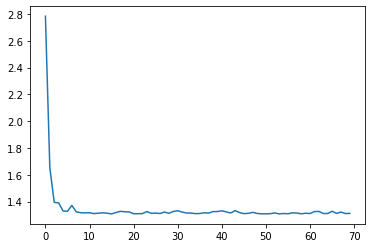

Epoch 1/100
7/7 - 9s - loss: 2.8870 - accuracy: 0.2860 - auc_52: 0.5900 - precision_52: 0.2784 - recall_52: 0.2279 - f1_score: 0.2256 - val_loss: 2.2481 - val_accuracy: 0.3832 - val_auc_52: 0.6159 - val_precision_52: 0.3832 - val_recall_52: 0.3832 - val_f1_score: 0.1385 - 9s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.5964 - accuracy: 0.2837 - auc_52: 0.5611 - precision_52: 0.4010 - recall_52: 0.1791 - f1_score: 0.1907 - val_loss: 1.4738 - val_accuracy: 0.1869 - val_auc_52: 0.4381 - val_precision_52: 0.0000e+00 - val_recall_52: 0.0000e+00 - val_f1_score: 0.0787 - 762ms/epoch - 109ms/step
Epoch 3/100
7/7 - 1s - loss: 1.4112 - accuracy: 0.3674 - auc_52: 0.5949 - precision_52: 0.3678 - recall_52: 0.1488 - f1_score: 0.2064 - val_loss: 1.4645 - val_accuracy: 0.3832 - val_auc_52: 0.6075 - val_precision_52: 0.0000e+00 - val_recall_52: 0.0000e+00 - val_f1_score: 0.1385 - 743ms/epoch - 106ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3615 - accuracy: 0.3674 - auc_52: 0.6152 - precision_52: 0.0000e+

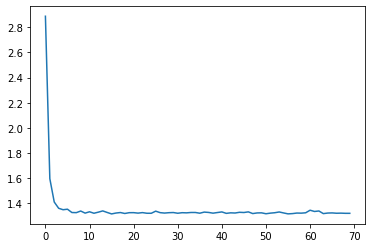

Epoch 1/100
7/7 - 10s - loss: 3.5289 - accuracy: 0.3233 - auc_53: 0.5704 - precision_53: 0.3005 - recall_53: 0.2558 - f1_score: 0.2304 - val_loss: 1.5154 - val_accuracy: 0.3645 - val_auc_53: 0.6246 - val_precision_53: 0.4062 - val_recall_53: 0.3645 - val_f1_score: 0.1364 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.4973 - accuracy: 0.3372 - auc_53: 0.5847 - precision_53: 0.4337 - recall_53: 0.2512 - f1_score: 0.1676 - val_loss: 1.3851 - val_accuracy: 0.3738 - val_auc_53: 0.5654 - val_precision_53: 0.0000e+00 - val_recall_53: 0.0000e+00 - val_f1_score: 0.1600 - 769ms/epoch - 110ms/step
Epoch 3/100
7/7 - 1s - loss: 1.3344 - accuracy: 0.3977 - auc_53: 0.6210 - precision_53: 0.0000e+00 - recall_53: 0.0000e+00 - f1_score: 0.1565 - val_loss: 1.3642 - val_accuracy: 0.3925 - val_auc_53: 0.6088 - val_precision_53: 0.0000e+00 - val_recall_53: 0.0000e+00 - val_f1_score: 0.1409 - 760ms/epoch - 109ms/step
Epoch 4/100
7/7 - 1s - loss: 1.3524 - accuracy: 0.3977 - auc_53: 0.6197 - precision_53

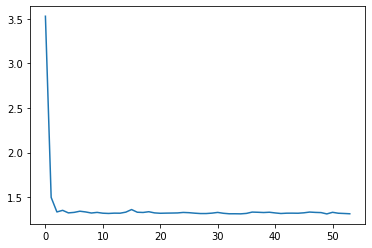

Epoch 1/100
7/7 - 9s - loss: 3.1510 - accuracy: 0.3186 - auc_54: 0.5797 - precision_54: 0.3417 - recall_54: 0.2837 - f1_score: 0.2084 - val_loss: 1.6307 - val_accuracy: 0.1776 - val_auc_54: 0.5023 - val_precision_54: 0.0909 - val_recall_54: 0.0093 - val_f1_score: 0.0754 - 9s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 1.6645 - accuracy: 0.2070 - auc_54: 0.4942 - precision_54: 0.2227 - recall_54: 0.1279 - f1_score: 0.1716 - val_loss: 1.3860 - val_accuracy: 0.4486 - val_auc_54: 0.6120 - val_precision_54: 0.4486 - val_recall_54: 0.4486 - val_f1_score: 0.1548 - 769ms/epoch - 110ms/step
Epoch 3/100
7/7 - 1s - loss: 1.4557 - accuracy: 0.2907 - auc_54: 0.5905 - precision_54: 0.3316 - recall_54: 0.1488 - f1_score: 0.1741 - val_loss: 1.3309 - val_accuracy: 0.2617 - val_auc_54: 0.6192 - val_precision_54: 0.0000e+00 - val_recall_54: 0.0000e+00 - val_f1_score: 0.1037 - 776ms/epoch - 111ms/step
Epoch 4/100
7/7 - 1s - loss: 1.4260 - accuracy: 0.3349 - auc_54: 0.6011 - precision_54: 0.3448 - recall_

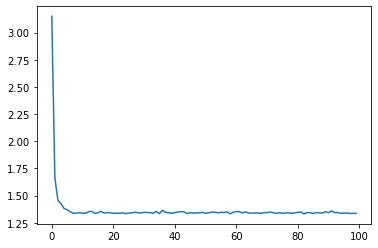

In [60]:
early_convLSTM_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'early_convLSTM.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(early_X):
    X_train, X_val = early_X[train_index], early_X[val_index]
    y_train, y_val = early_y[train_index], early_y[val_index]
    early_convLSTM = build_convLSTM(early_features, n_length, early_outputs)
    history = train(early_convLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        early_convLSTM.save(early_convLSTM_model_path)

In [61]:
early_convlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_convlstm_train_results

{'Accuracy': 0.4082994520664215,
 'ROC/AUC': 0.632660973072052,
 'Precision': 0.13999999761581422,
 'Recall': 0.006526806205511093,
 'F1-score': 0.17559810280799865}

In [62]:
early_convlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_convlstm_val_results

{'Accuracy': 0.39856351613998414,
 'ROC/AUC': 0.6124220967292786,
 'Precision': 0.1,
 'Recall': 0.0018518518656492234,
 'F1-score': 0.16208251416683198}

### Train RCNN (with early fusion)

In [63]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 2s - loss: 22.3810 - accuracy: 0.2284 - auc_55: 0.4940 - precision_55: 0.2461 - recall_55: 0.2191 - f1_score: 0.2216 - val_loss: 47.7909 - val_accuracy: 0.1019 - val_auc_55: 0.4242 - val_precision_55: 0.0769 - val_recall_55: 0.0185 - val_f1_score: 0.0716 - 2s/epoch - 228ms/step
Epoch 2/100
7/7 - 0s - loss: 10.7369 - accuracy: 0.2890 - auc_55: 0.5594 - precision_55: 0.2890 - recall_55: 0.2890 - f1_score: 0.2353 - val_loss: 15.4592 - val_accuracy: 0.3889 - val_auc_55: 0.6029 - val_precision_55: 0.3736 - val_recall_55: 0.3148 - val_f1_score: 0.1932 - 129ms/epoch - 18ms/step
Epoch 3/100
7/7 - 0s - loss: 6.6527 - accuracy: 0.2517 - auc_55: 0.5186 - precision_55: 0.2676 - recall_55: 0.2121 - f1_score: 0.2399 - val_loss: 7.2675 - val_accuracy: 0.3704 - val_auc_55: 0.5836 - val_precision_55: 0.2308 - val_recall_55: 0.0556 - val_f1_score: 0.1909 - 133ms/epoch - 19ms/step
Epoch 4/100
7/7 - 0s - loss: 4.3989 - accuracy: 0.4009 - auc_55: 0.5857 - precision_55: 0.3993 - recall_55:

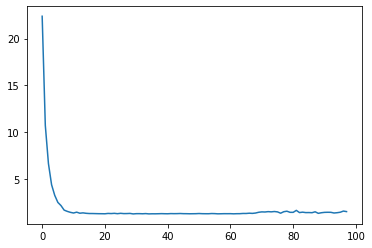

Epoch 1/100
7/7 - 2s - loss: 31.5712 - accuracy: 0.2984 - auc_56: 0.5326 - precision_56: 0.3053 - recall_56: 0.2704 - f1_score: 0.2667 - val_loss: 36.4492 - val_accuracy: 0.2130 - val_auc_56: 0.5346 - val_precision_56: 0.2130 - val_recall_56: 0.2130 - val_f1_score: 0.1366 - 2s/epoch - 233ms/step
Epoch 2/100
7/7 - 0s - loss: 16.2869 - accuracy: 0.3403 - auc_56: 0.5901 - precision_56: 0.3403 - recall_56: 0.3403 - f1_score: 0.2655 - val_loss: 10.2168 - val_accuracy: 0.2130 - val_auc_56: 0.4629 - val_precision_56: 0.3478 - val_recall_56: 0.0741 - val_f1_score: 0.1497 - 135ms/epoch - 19ms/step
Epoch 3/100
7/7 - 0s - loss: 6.0180 - accuracy: 0.3427 - auc_56: 0.5559 - precision_56: 0.3427 - recall_56: 0.3427 - f1_score: 0.2913 - val_loss: 6.4514 - val_accuracy: 0.3519 - val_auc_56: 0.5383 - val_precision_56: 0.1739 - val_recall_56: 0.0370 - val_f1_score: 0.1936 - 133ms/epoch - 19ms/step
Epoch 4/100
7/7 - 0s - loss: 3.5223 - accuracy: 0.2401 - auc_56: 0.5374 - precision_56: 0.2671 - recall_56:

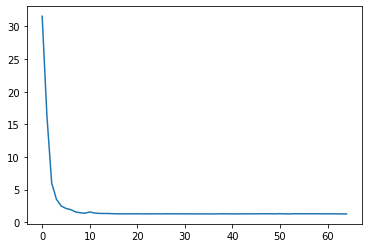

Epoch 1/100
7/7 - 2s - loss: 33.8839 - accuracy: 0.2605 - auc_57: 0.5174 - precision_57: 0.2768 - recall_57: 0.2465 - f1_score: 0.2298 - val_loss: 57.5679 - val_accuracy: 0.3738 - val_auc_57: 0.5646 - val_precision_57: 0.3738 - val_recall_57: 0.3738 - val_f1_score: 0.2062 - 2s/epoch - 339ms/step
Epoch 2/100
7/7 - 0s - loss: 13.8540 - accuracy: 0.2628 - auc_57: 0.4911 - precision_57: 0.2628 - recall_57: 0.2628 - f1_score: 0.2058 - val_loss: 18.6504 - val_accuracy: 0.3645 - val_auc_57: 0.5547 - val_precision_57: 0.2222 - val_recall_57: 0.0561 - val_f1_score: 0.1373 - 131ms/epoch - 19ms/step
Epoch 3/100
7/7 - 0s - loss: 6.0465 - accuracy: 0.2209 - auc_57: 0.4822 - precision_57: 0.2539 - recall_57: 0.1907 - f1_score: 0.1739 - val_loss: 10.0424 - val_accuracy: 0.2430 - val_auc_57: 0.5456 - val_precision_57: 0.3077 - val_recall_57: 0.0748 - val_f1_score: 0.1946 - 135ms/epoch - 19ms/step
Epoch 4/100
7/7 - 0s - loss: 2.6809 - accuracy: 0.3209 - auc_57: 0.5796 - precision_57: 0.3333 - recall_57

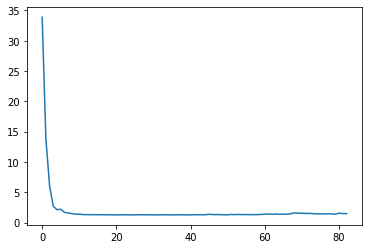

Epoch 1/100
7/7 - 2s - loss: 23.8134 - accuracy: 0.3163 - auc_58: 0.5546 - precision_58: 0.3386 - recall_58: 0.3000 - f1_score: 0.2730 - val_loss: 37.4817 - val_accuracy: 0.2710 - val_auc_58: 0.5380 - val_precision_58: 0.3333 - val_recall_58: 0.1028 - val_f1_score: 0.1692 - 2s/epoch - 222ms/step
Epoch 2/100
7/7 - 0s - loss: 8.4354 - accuracy: 0.2674 - auc_58: 0.4960 - precision_58: 0.2681 - recall_58: 0.2674 - f1_score: 0.2134 - val_loss: 8.5227 - val_accuracy: 0.3832 - val_auc_58: 0.5803 - val_precision_58: 0.3832 - val_recall_58: 0.3832 - val_f1_score: 0.2312 - 132ms/epoch - 19ms/step
Epoch 3/100
7/7 - 0s - loss: 4.3643 - accuracy: 0.2628 - auc_58: 0.5536 - precision_58: 0.2492 - recall_58: 0.1860 - f1_score: 0.2483 - val_loss: 5.1763 - val_accuracy: 0.1963 - val_auc_58: 0.5134 - val_precision_58: 0.2121 - val_recall_58: 0.0654 - val_f1_score: 0.1750 - 134ms/epoch - 19ms/step
Epoch 4/100
7/7 - 0s - loss: 2.7120 - accuracy: 0.3465 - auc_58: 0.5868 - precision_58: 0.3457 - recall_58: 0

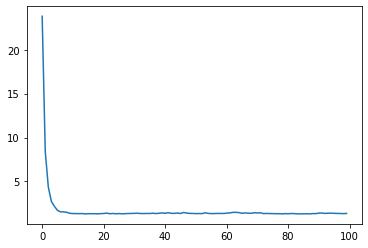

Epoch 1/100
7/7 - 2s - loss: 26.4112 - accuracy: 0.2326 - auc_59: 0.4875 - precision_59: 0.2454 - recall_59: 0.2186 - f1_score: 0.2281 - val_loss: 53.4853 - val_accuracy: 0.4019 - val_auc_59: 0.5598 - val_precision_59: 0.4019 - val_recall_59: 0.4019 - val_f1_score: 0.1767 - 2s/epoch - 219ms/step
Epoch 2/100
7/7 - 0s - loss: 13.6086 - accuracy: 0.3070 - auc_59: 0.5842 - precision_59: 0.3154 - recall_59: 0.2860 - f1_score: 0.2654 - val_loss: 8.8004 - val_accuracy: 0.4112 - val_auc_59: 0.6126 - val_precision_59: 0.3200 - val_recall_59: 0.0748 - val_f1_score: 0.1947 - 128ms/epoch - 18ms/step
Epoch 3/100
7/7 - 0s - loss: 5.1048 - accuracy: 0.3140 - auc_59: 0.5472 - precision_59: 0.3138 - recall_59: 0.3116 - f1_score: 0.2496 - val_loss: 2.5833 - val_accuracy: 0.4112 - val_auc_59: 0.6222 - val_precision_59: 0.3200 - val_recall_59: 0.0748 - val_f1_score: 0.2604 - 125ms/epoch - 18ms/step
Epoch 4/100
7/7 - 0s - loss: 3.2864 - accuracy: 0.2326 - auc_59: 0.5140 - precision_59: 0.2308 - recall_59: 

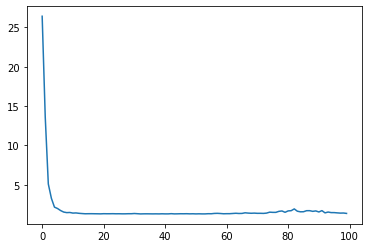

In [64]:
early_rcnn_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'early_rcnn.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(early_X):
    X_train, X_val = early_X[train_index], early_X[val_index]
    y_train, y_val = early_y[train_index], early_y[val_index]
    early_rcnn = build_RCNN(early_features, n_length, early_outputs)
    history = train(early_rcnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        early_rcnn.save(early_rcnn_model_path)

In [65]:
early_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_rcnn_train_results

{'Accuracy': 0.41015992164611814,
 'ROC/AUC': 0.6336613655090332,
 'Precision': 0.4276616871356964,
 'Recall': 0.09449666664004326,
 'F1-score': 0.23422228395938874}

In [66]:
early_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_rcnn_val_results

{'Accuracy': 0.35932848453521726,
 'ROC/AUC': 0.5867252469062805,
 'Precision': 0.2573504313826561,
 'Recall': 0.04096573106944561,
 'F1-score': 0.17887080907821656}

## 3. Late Fusion - Fusion is performed at decision level

In late fusion, I test two approaches, in both uni-modal classifiers are trained individually, and then either: 

- Their final dense (decision) layer is concatenated to produce the final prediction; or 

- Ensemble the uni-modal classifiers.

Just as with early fusion, we have the issue that the face modality is missing about half of the times and therefore, I can only use late fusion if both modalities are present.

### About the data

In [83]:
body_X_train, body_X_test, y_train, y_test = load_latefusion_dataset('processed', 'skeleton')
body_X = body_X_train.copy()
y = y_train.copy()

print(body_X_train.shape, y_train.shape)
print(body_X_test.shape, y_test.shape)

n_length, body_features, body_outputs = body_X_train.shape[2], body_X_train.shape[-1], y_train.shape[1]

(537, 1, 350, 38) (537, 4)
(60, 1, 350, 38) (60, 4)


In [68]:
umild, lmoderate, lmild, umoderate = np.sum(y_train, axis=0)
total = umild + lmoderate + lmild + umoderate

weight_for_0 = (1 / umild) * (total / 2.0)
weight_for_1 = (1 / lmoderate) * (total / 2.0)
weight_for_2 = (1 / lmild) * (total / 2.0)
weight_for_3 = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

### CNN+LSTM (concatenate decision layer)

In [69]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 16s - loss: 1.3583 - accuracy: 0.3543 - auc_60: 0.6105 - precision_60: 0.4725 - recall_60: 0.1002 - f1_score: 0.2084 - val_loss: 1.3689 - val_accuracy: 0.3796 - val_auc_60: 0.5491 - val_precision_60: 0.0000e+00 - val_recall_60: 0.0000e+00 - val_f1_score: 0.1376 - 16s/epoch - 2s/step
Epoch 2/100
7/7 - 0s - loss: 1.3282 - accuracy: 0.3753 - auc_60: 0.6329 - precision_60: 0.2941 - recall_60: 0.0117 - f1_score: 0.2044 - val_loss: 1.3821 - val_accuracy: 0.3796 - val_auc_60: 0.5650 - val_precision_60: 0.4286 - val_recall_60: 0.0278 - val_f1_score: 0.1376 - 428ms/epoch - 61ms/step
Epoch 3/100
7/7 - 0s - loss: 1.2704 - accuracy: 0.4219 - auc_60: 0.6872 - precision_60: 0.7857 - recall_60: 0.0256 - f1_score: 0.2565 - val_loss: 1.3744 - val_accuracy: 0.3519 - val_auc_60: 0.6132 - val_precision_60: 0.5385 - val_recall_60: 0.0648 - val_f1_score: 0.1556 - 434ms/epoch - 62ms/step
Epoch 4/100
7/7 - 0s - loss: 1.2583 - accuracy: 0.4266 - auc_60: 0.6912 - precision_60: 0.5463 - recall_

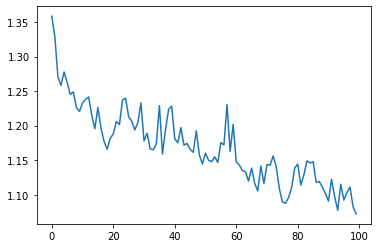

Epoch 1/100
7/7 - 16s - loss: 1.3650 - accuracy: 0.3800 - auc_61: 0.6073 - precision_61: 0.3279 - recall_61: 0.0466 - f1_score: 0.2151 - val_loss: 1.3589 - val_accuracy: 0.3796 - val_auc_61: 0.6029 - val_precision_61: 0.0000e+00 - val_recall_61: 0.0000e+00 - val_f1_score: 0.1376 - 16s/epoch - 2s/step
Epoch 2/100
7/7 - 1s - loss: 1.2897 - accuracy: 0.4103 - auc_61: 0.6694 - precision_61: 0.4722 - recall_61: 0.0396 - f1_score: 0.2309 - val_loss: 1.3038 - val_accuracy: 0.3981 - val_auc_61: 0.6556 - val_precision_61: 0.5000 - val_recall_61: 0.0370 - val_f1_score: 0.2022 - 549ms/epoch - 78ms/step
Epoch 3/100
7/7 - 0s - loss: 1.2633 - accuracy: 0.4266 - auc_61: 0.6856 - precision_61: 0.5606 - recall_61: 0.0862 - f1_score: 0.2541 - val_loss: 1.3517 - val_accuracy: 0.3241 - val_auc_61: 0.6010 - val_precision_61: 0.0000e+00 - val_recall_61: 0.0000e+00 - val_f1_score: 0.2673 - 424ms/epoch - 61ms/step
Epoch 4/100
7/7 - 0s - loss: 1.2510 - accuracy: 0.4103 - auc_61: 0.6914 - precision_61: 0.5938 -

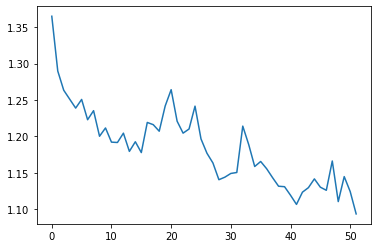

Epoch 1/100
7/7 - 16s - loss: 1.3618 - accuracy: 0.3465 - auc_62: 0.6080 - precision_62: 0.4308 - recall_62: 0.0651 - f1_score: 0.2558 - val_loss: 1.4082 - val_accuracy: 0.3832 - val_auc_62: 0.5944 - val_precision_62: 0.0000e+00 - val_recall_62: 0.0000e+00 - val_f1_score: 0.1385 - 16s/epoch - 2s/step
Epoch 2/100
7/7 - 1s - loss: 1.3095 - accuracy: 0.3814 - auc_62: 0.6516 - precision_62: 0.4839 - recall_62: 0.0349 - f1_score: 0.1977 - val_loss: 1.3466 - val_accuracy: 0.3832 - val_auc_62: 0.6067 - val_precision_62: 0.0000e+00 - val_recall_62: 0.0000e+00 - val_f1_score: 0.1385 - 549ms/epoch - 78ms/step
Epoch 3/100
7/7 - 0s - loss: 1.2852 - accuracy: 0.4047 - auc_62: 0.6704 - precision_62: 0.6167 - recall_62: 0.0860 - f1_score: 0.2430 - val_loss: 1.3946 - val_accuracy: 0.3645 - val_auc_62: 0.6063 - val_precision_62: 0.2353 - val_recall_62: 0.0374 - val_f1_score: 0.1627 - 416ms/epoch - 59ms/step
Epoch 4/100
7/7 - 0s - loss: 1.2498 - accuracy: 0.4000 - auc_62: 0.6909 - precision_62: 0.6279 -

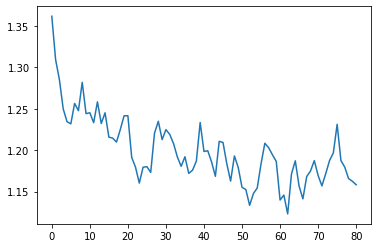

Epoch 1/100
7/7 - 17s - loss: 1.3981 - accuracy: 0.3605 - auc_63: 0.5859 - precision_63: 0.4118 - recall_63: 0.0977 - f1_score: 0.2095 - val_loss: 1.3371 - val_accuracy: 0.3925 - val_auc_63: 0.6349 - val_precision_63: 0.0000e+00 - val_recall_63: 0.0000e+00 - val_f1_score: 0.1409 - 17s/epoch - 2s/step
Epoch 2/100
7/7 - 1s - loss: 1.3355 - accuracy: 0.4000 - auc_63: 0.6324 - precision_63: 0.0000e+00 - recall_63: 0.0000e+00 - f1_score: 0.2018 - val_loss: 1.3177 - val_accuracy: 0.3925 - val_auc_63: 0.6467 - val_precision_63: 0.0000e+00 - val_recall_63: 0.0000e+00 - val_f1_score: 0.1409 - 548ms/epoch - 78ms/step
Epoch 3/100
7/7 - 0s - loss: 1.3121 - accuracy: 0.4023 - auc_63: 0.6453 - precision_63: 0.3750 - recall_63: 0.0140 - f1_score: 0.1753 - val_loss: 1.3292 - val_accuracy: 0.3925 - val_auc_63: 0.6309 - val_precision_63: 0.0000e+00 - val_recall_63: 0.0000e+00 - val_f1_score: 0.1409 - 413ms/epoch - 59ms/step
Epoch 4/100
7/7 - 0s - loss: 1.2918 - accuracy: 0.4093 - auc_63: 0.6684 - precis

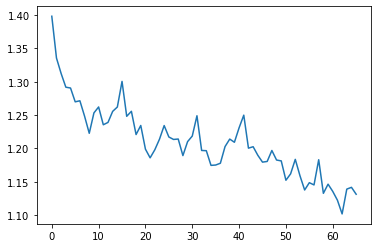

Epoch 1/100
7/7 - 16s - loss: 1.3970 - accuracy: 0.3465 - auc_64: 0.5970 - precision_64: 0.3832 - recall_64: 0.0953 - f1_score: 0.2367 - val_loss: 1.3279 - val_accuracy: 0.4486 - val_auc_64: 0.6127 - val_precision_64: 0.0000e+00 - val_recall_64: 0.0000e+00 - val_f1_score: 0.1548 - 16s/epoch - 2s/step
Epoch 2/100
7/7 - 0s - loss: 1.3291 - accuracy: 0.3186 - auc_64: 0.6223 - precision_64: 1.0000 - recall_64: 0.0047 - f1_score: 0.2511 - val_loss: 1.3434 - val_accuracy: 0.4486 - val_auc_64: 0.6082 - val_precision_64: 0.0000e+00 - val_recall_64: 0.0000e+00 - val_f1_score: 0.1548 - 421ms/epoch - 60ms/step
Epoch 3/100
7/7 - 1s - loss: 1.2909 - accuracy: 0.3860 - auc_64: 0.6694 - precision_64: 0.4667 - recall_64: 0.1302 - f1_score: 0.1795 - val_loss: 1.3022 - val_accuracy: 0.4673 - val_auc_64: 0.6476 - val_precision_64: 1.0000 - val_recall_64: 0.0093 - val_f1_score: 0.2024 - 559ms/epoch - 80ms/step
Epoch 4/100
7/7 - 1s - loss: 1.2583 - accuracy: 0.4279 - auc_64: 0.6954 - precision_64: 0.5625 -

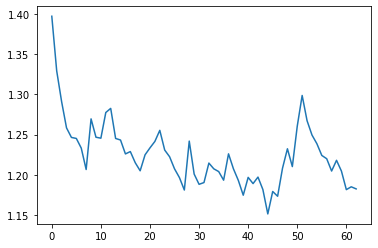

In [70]:
late_cnnlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'late_cnnlstm.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    head_X_train, head_X_val = head_X[train_index], head_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    late_cnnlstm = build_fusioned_CNNLSTM(body_features, face_features, head_features, n_length, body_outputs)
    history = train_fusioned(late_cnnlstm, body_X_train, face_X_train, head_X_train, y_train, body_X_val, face_X_val, head_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        late_cnnlstm.save(late_cnnlstm_model_path)

In [71]:
late_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_cnnlstm_train_results

{'Accuracy': 0.494911915063858,
 'ROC/AUC': 0.7592286705970764,
 'Precision': 0.6514186859130859,
 'Recall': 0.2593256324529648,
 'F1-score': 0.41927379965782163}

In [72]:
late_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_cnnlstm_val_results

{'Accuracy': 0.2848217338323593,
 'ROC/AUC': 0.5697753429412842,
 'Precision': 0.3049425303936005,
 'Recall': 0.11540325507521629,
 'F1-score': 0.22759883105754852}

### ConvLSTM (concatenate decision layer)

In [92]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 29s - loss: 3.4610 - accuracy: 0.2867 - auc_66: 0.5522 - precision_66: 0.3033 - recall_66: 0.2121 - f1_score: 0.2402 - val_loss: 1.6786 - val_accuracy: 0.3148 - val_auc_66: 0.6158 - val_precision_66: 0.2364 - val_recall_66: 0.1204 - val_f1_score: 0.1298 - 29s/epoch - 4s/step
Epoch 2/100
7/7 - 2s - loss: 1.7473 - accuracy: 0.2821 - auc_66: 0.5684 - precision_66: 0.3269 - recall_66: 0.1585 - f1_score: 0.2476 - val_loss: 1.6058 - val_accuracy: 0.1204 - val_auc_66: 0.4726 - val_precision_66: 0.1429 - val_recall_66: 0.0278 - val_f1_score: 0.0899 - 2s/epoch - 324ms/step
Epoch 3/100
7/7 - 2s - loss: 1.4584 - accuracy: 0.3357 - auc_66: 0.5855 - precision_66: 0.4646 - recall_66: 0.1072 - f1_score: 0.2463 - val_loss: 1.4871 - val_accuracy: 0.3241 - val_auc_66: 0.6064 - val_precision_66: 0.5333 - val_recall_66: 0.0741 - val_f1_score: 0.1992 - 2s/epoch - 304ms/step
Epoch 4/100
7/7 - 2s - loss: 1.3616 - accuracy: 0.3893 - auc_66: 0.6364 - precision_66: 0.5432 - recall_66: 0.1026 -

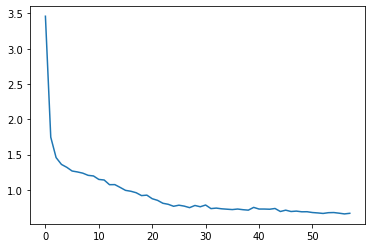

Epoch 1/100
7/7 - 27s - loss: 3.9777 - accuracy: 0.3030 - auc_67: 0.5511 - precision_67: 0.3037 - recall_67: 0.2471 - f1_score: 0.2574 - val_loss: 1.5141 - val_accuracy: 0.3889 - val_auc_67: 0.6221 - val_precision_67: 0.3878 - val_recall_67: 0.3519 - val_f1_score: 0.1817 - 27s/epoch - 4s/step
Epoch 2/100
7/7 - 2s - loss: 1.6184 - accuracy: 0.3403 - auc_67: 0.6337 - precision_67: 0.3640 - recall_67: 0.2308 - f1_score: 0.2405 - val_loss: 1.6965 - val_accuracy: 0.2315 - val_auc_67: 0.5191 - val_precision_67: 0.0968 - val_recall_67: 0.0278 - val_f1_score: 0.1341 - 2s/epoch - 287ms/step
Epoch 3/100
7/7 - 2s - loss: 1.4127 - accuracy: 0.4009 - auc_67: 0.6247 - precision_67: 0.4545 - recall_67: 0.0816 - f1_score: 0.2378 - val_loss: 1.4900 - val_accuracy: 0.3796 - val_auc_67: 0.5791 - val_precision_67: 0.3333 - val_recall_67: 0.0741 - val_f1_score: 0.1376 - 2s/epoch - 304ms/step
Epoch 4/100
7/7 - 2s - loss: 1.3110 - accuracy: 0.3823 - auc_67: 0.6662 - precision_67: 0.5000 - recall_67: 0.1375 -

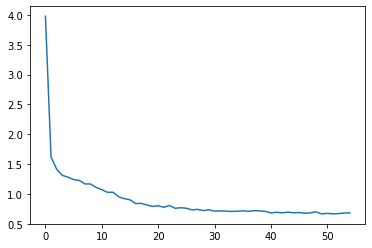

Epoch 1/100
7/7 - 28s - loss: 3.1937 - accuracy: 0.3512 - auc_68: 0.6040 - precision_68: 0.3440 - recall_68: 0.2744 - f1_score: 0.2683 - val_loss: 2.3152 - val_accuracy: 0.1589 - val_auc_68: 0.4116 - val_precision_68: 0.1695 - val_recall_68: 0.0935 - val_f1_score: 0.1131 - 28s/epoch - 4s/step
Epoch 2/100
7/7 - 2s - loss: 1.6861 - accuracy: 0.3000 - auc_68: 0.5719 - precision_68: 0.3086 - recall_68: 0.1744 - f1_score: 0.2739 - val_loss: 1.5751 - val_accuracy: 0.3178 - val_auc_68: 0.5870 - val_precision_68: 0.2500 - val_recall_68: 0.0187 - val_f1_score: 0.1741 - 2s/epoch - 308ms/step
Epoch 3/100
7/7 - 2s - loss: 1.3994 - accuracy: 0.3698 - auc_68: 0.5905 - precision_68: 0.3846 - recall_68: 0.0349 - f1_score: 0.2644 - val_loss: 1.4531 - val_accuracy: 0.4112 - val_auc_68: 0.6037 - val_precision_68: 0.3333 - val_recall_68: 0.0093 - val_f1_score: 0.2099 - 2s/epoch - 306ms/step
Epoch 4/100
7/7 - 2s - loss: 1.3503 - accuracy: 0.3977 - auc_68: 0.6610 - precision_68: 0.4569 - recall_68: 0.2093 -

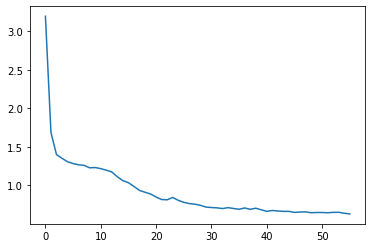

Epoch 1/100
7/7 - 27s - loss: 2.8209 - accuracy: 0.3256 - auc_69: 0.5891 - precision_69: 0.3258 - recall_69: 0.2698 - f1_score: 0.2211 - val_loss: 1.5433 - val_accuracy: 0.2430 - val_auc_69: 0.5623 - val_precision_69: 0.1944 - val_recall_69: 0.0654 - val_f1_score: 0.1528 - 27s/epoch - 4s/step
Epoch 2/100
7/7 - 2s - loss: 1.4725 - accuracy: 0.2953 - auc_69: 0.5593 - precision_69: 0.3659 - recall_69: 0.1395 - f1_score: 0.2638 - val_loss: 1.5132 - val_accuracy: 0.3925 - val_auc_69: 0.5947 - val_precision_69: 0.4100 - val_recall_69: 0.3832 - val_f1_score: 0.1409 - 2s/epoch - 308ms/step
Epoch 3/100
7/7 - 2s - loss: 1.4014 - accuracy: 0.3372 - auc_69: 0.6086 - precision_69: 0.3945 - recall_69: 0.1000 - f1_score: 0.2300 - val_loss: 1.3556 - val_accuracy: 0.3925 - val_auc_69: 0.6392 - val_precision_69: 0.6400 - val_recall_69: 0.1495 - val_f1_score: 0.1788 - 2s/epoch - 309ms/step
Epoch 4/100
7/7 - 2s - loss: 1.3167 - accuracy: 0.4000 - auc_69: 0.6507 - precision_69: 0.5326 - recall_69: 0.1140 -

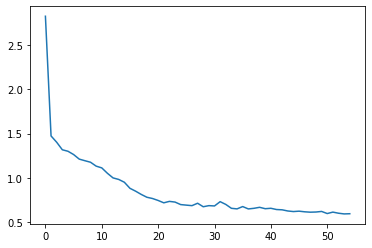

Epoch 1/100
7/7 - 29s - loss: 2.8165 - accuracy: 0.3140 - auc_70: 0.5966 - precision_70: 0.3583 - recall_70: 0.2116 - f1_score: 0.2734 - val_loss: 1.8115 - val_accuracy: 0.1589 - val_auc_70: 0.4481 - val_precision_70: 0.1500 - val_recall_70: 0.0561 - val_f1_score: 0.1250 - 29s/epoch - 4s/step
Epoch 2/100
7/7 - 2s - loss: 1.4845 - accuracy: 0.3326 - auc_70: 0.6056 - precision_70: 0.3663 - recall_70: 0.1465 - f1_score: 0.3161 - val_loss: 1.3790 - val_accuracy: 0.4019 - val_auc_70: 0.6440 - val_precision_70: 0.3000 - val_recall_70: 0.0561 - val_f1_score: 0.2263 - 2s/epoch - 321ms/step
Epoch 3/100
7/7 - 2s - loss: 1.4601 - accuracy: 0.3093 - auc_70: 0.5789 - precision_70: 0.3623 - recall_70: 0.0581 - f1_score: 0.2291 - val_loss: 1.3411 - val_accuracy: 0.2617 - val_auc_70: 0.6325 - val_precision_70: 0.2500 - val_recall_70: 0.0187 - val_f1_score: 0.1622 - 2s/epoch - 309ms/step
Epoch 4/100
7/7 - 2s - loss: 1.3446 - accuracy: 0.3512 - auc_70: 0.6411 - precision_70: 0.5258 - recall_70: 0.1186 -

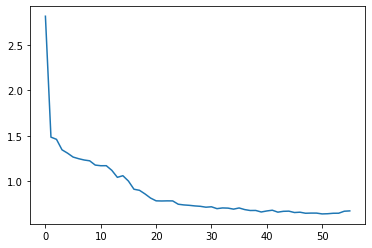

In [93]:
late_convlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'late_convlstm.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    head_X_train, head_X_val = head_X[train_index], head_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    late_convlstm = build_fusioned_convLSTM(body_features, face_features, head_features, n_length, body_outputs)
    history = train_fusioned(late_convlstm, body_X_train, face_X_train, head_X_train, y_train, body_X_val, face_X_val, head_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        late_convlstm.save(late_convlstm_model_path)

In [94]:
late_convlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_convlstm_train_results

{'Accuracy': 0.6601398587226868,
 'ROC/AUC': 0.9136343479156495,
 'Precision': 0.8690954566001892,
 'Recall': 0.5372353315353393,
 'F1-score': 0.6485125780105591}

In [95]:
late_convlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_convlstm_val_results

{'Accuracy': 0.3744029104709625,
 'ROC/AUC': 0.6376629590988159,
 'Precision': 0.42861146926879884,
 'Recall': 0.2589650332927704,
 'F1-score': 0.2915247231721878}

### RCNN (concatenate decision layer)

In [96]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

Epoch 1/100
7/7 - 4s - loss: 12.1437 - accuracy: 0.2890 - auc_71: 0.5344 - precision_71: 0.3018 - recall_71: 0.2751 - f1_score: 0.2440 - val_loss: 38.6161 - val_accuracy: 0.2315 - val_auc_71: 0.4877 - val_precision_71: 0.2315 - val_recall_71: 0.2315 - val_f1_score: 0.0940 - 4s/epoch - 524ms/step
Epoch 2/100
7/7 - 0s - loss: 4.7250 - accuracy: 0.3636 - auc_71: 0.6167 - precision_71: 0.3702 - recall_71: 0.3590 - f1_score: 0.3414 - val_loss: 13.4597 - val_accuracy: 0.3056 - val_auc_71: 0.5382 - val_precision_71: 0.3056 - val_recall_71: 0.3056 - val_f1_score: 0.1187 - 337ms/epoch - 48ms/step
Epoch 3/100
7/7 - 0s - loss: 2.3290 - accuracy: 0.4312 - auc_71: 0.6896 - precision_71: 0.4338 - recall_71: 0.3893 - f1_score: 0.4058 - val_loss: 4.4408 - val_accuracy: 0.1759 - val_auc_71: 0.4191 - val_precision_71: 0.1818 - val_recall_71: 0.1667 - val_f1_score: 0.1344 - 348ms/epoch - 50ms/step
Epoch 4/100
7/7 - 0s - loss: 2.2224 - accuracy: 0.4359 - auc_71: 0.6967 - precision_71: 0.4696 - recall_71: 

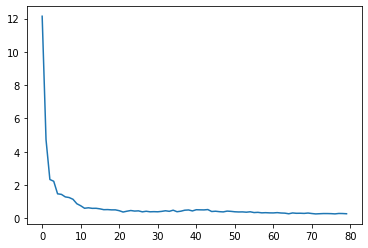

Epoch 1/100
7/7 - 4s - loss: 9.1673 - accuracy: 0.2821 - auc_72: 0.5421 - precision_72: 0.2884 - recall_72: 0.2541 - f1_score: 0.2416 - val_loss: 31.0494 - val_accuracy: 0.1944 - val_auc_72: 0.4642 - val_precision_72: 0.1944 - val_recall_72: 0.1944 - val_f1_score: 0.0814 - 4s/epoch - 529ms/step
Epoch 2/100
7/7 - 0s - loss: 3.0064 - accuracy: 0.3846 - auc_72: 0.6362 - precision_72: 0.3995 - recall_72: 0.3566 - f1_score: 0.3546 - val_loss: 15.8958 - val_accuracy: 0.3981 - val_auc_72: 0.6020 - val_precision_72: 0.3981 - val_recall_72: 0.3981 - val_f1_score: 0.1816 - 355ms/epoch - 51ms/step
Epoch 3/100
7/7 - 0s - loss: 3.0859 - accuracy: 0.4312 - auc_72: 0.6870 - precision_72: 0.4356 - recall_72: 0.4103 - f1_score: 0.4055 - val_loss: 10.6403 - val_accuracy: 0.1944 - val_auc_72: 0.4468 - val_precision_72: 0.1963 - val_recall_72: 0.1944 - val_f1_score: 0.1338 - 344ms/epoch - 49ms/step
Epoch 4/100
7/7 - 0s - loss: 1.9480 - accuracy: 0.5082 - auc_72: 0.7520 - precision_72: 0.5380 - recall_72: 

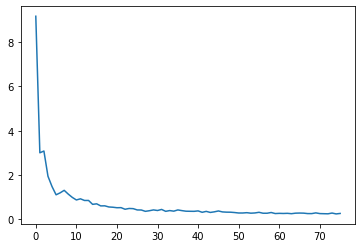

Epoch 1/100
7/7 - 5s - loss: 12.6414 - accuracy: 0.2744 - auc_73: 0.5370 - precision_73: 0.2762 - recall_73: 0.2512 - f1_score: 0.2486 - val_loss: 24.1656 - val_accuracy: 0.1963 - val_auc_73: 0.4625 - val_precision_73: 0.1963 - val_recall_73: 0.1963 - val_f1_score: 0.1063 - 5s/epoch - 726ms/step
Epoch 2/100
7/7 - 0s - loss: 3.1740 - accuracy: 0.3698 - auc_73: 0.6264 - precision_73: 0.3772 - recall_73: 0.3465 - f1_score: 0.3403 - val_loss: 7.1471 - val_accuracy: 0.3364 - val_auc_73: 0.5633 - val_precision_73: 0.3364 - val_recall_73: 0.3364 - val_f1_score: 0.2078 - 341ms/epoch - 49ms/step
Epoch 3/100
7/7 - 0s - loss: 2.2639 - accuracy: 0.4512 - auc_73: 0.7087 - precision_73: 0.4550 - recall_73: 0.4233 - f1_score: 0.4114 - val_loss: 9.1592 - val_accuracy: 0.2336 - val_auc_73: 0.5022 - val_precision_73: 0.2336 - val_recall_73: 0.2336 - val_f1_score: 0.1231 - 282ms/epoch - 40ms/step
Epoch 4/100
7/7 - 0s - loss: 2.0510 - accuracy: 0.4907 - auc_73: 0.7368 - precision_73: 0.5092 - recall_73: 0

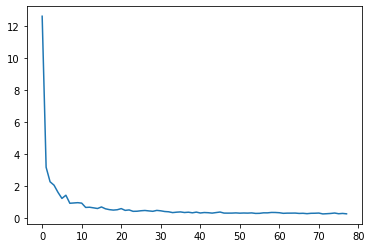

Epoch 1/100
7/7 - 4s - loss: 11.5157 - accuracy: 0.2721 - auc_74: 0.5431 - precision_74: 0.2774 - recall_74: 0.2535 - f1_score: 0.2323 - val_loss: 26.3011 - val_accuracy: 0.4112 - val_auc_74: 0.5989 - val_precision_74: 0.4112 - val_recall_74: 0.4112 - val_f1_score: 0.2435 - 4s/epoch - 520ms/step
Epoch 2/100
7/7 - 0s - loss: 3.4675 - accuracy: 0.3767 - auc_74: 0.6380 - precision_74: 0.3852 - recall_74: 0.3512 - f1_score: 0.3479 - val_loss: 13.7137 - val_accuracy: 0.1495 - val_auc_74: 0.4455 - val_precision_74: 0.1495 - val_recall_74: 0.1495 - val_f1_score: 0.0890 - 364ms/epoch - 52ms/step
Epoch 3/100
7/7 - 0s - loss: 3.1011 - accuracy: 0.4326 - auc_74: 0.6805 - precision_74: 0.4413 - recall_74: 0.4023 - f1_score: 0.4053 - val_loss: 10.2972 - val_accuracy: 0.3738 - val_auc_74: 0.6001 - val_precision_74: 0.3738 - val_recall_74: 0.3738 - val_f1_score: 0.1967 - 357ms/epoch - 51ms/step
Epoch 4/100
7/7 - 0s - loss: 2.4147 - accuracy: 0.4512 - auc_74: 0.7143 - precision_74: 0.4576 - recall_74:

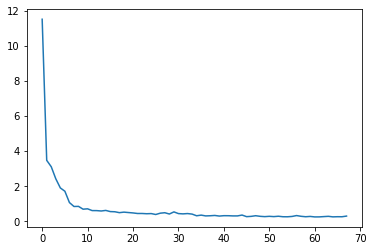

Epoch 1/100
7/7 - 4s - loss: 9.3420 - accuracy: 0.3186 - auc_75: 0.5457 - precision_75: 0.3175 - recall_75: 0.2791 - f1_score: 0.2652 - val_loss: 16.7483 - val_accuracy: 0.2150 - val_auc_75: 0.5304 - val_precision_75: 0.2150 - val_recall_75: 0.2150 - val_f1_score: 0.1314 - 4s/epoch - 531ms/step
Epoch 2/100
7/7 - 0s - loss: 4.2930 - accuracy: 0.3791 - auc_75: 0.6199 - precision_75: 0.3854 - recall_75: 0.3674 - f1_score: 0.3674 - val_loss: 28.2887 - val_accuracy: 0.4486 - val_auc_75: 0.6324 - val_precision_75: 0.4486 - val_recall_75: 0.4486 - val_f1_score: 0.1707 - 282ms/epoch - 40ms/step
Epoch 3/100
7/7 - 0s - loss: 2.5552 - accuracy: 0.3767 - auc_75: 0.6550 - precision_75: 0.3856 - recall_75: 0.3488 - f1_score: 0.3478 - val_loss: 3.2823 - val_accuracy: 0.3832 - val_auc_75: 0.6101 - val_precision_75: 0.3846 - val_recall_75: 0.3738 - val_f1_score: 0.2548 - 344ms/epoch - 49ms/step
Epoch 4/100
7/7 - 0s - loss: 1.7925 - accuracy: 0.4907 - auc_75: 0.7343 - precision_75: 0.5147 - recall_75: 0

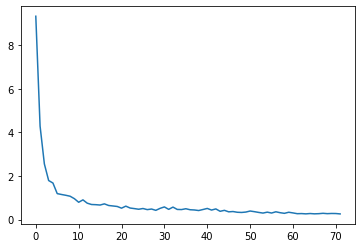

In [98]:
late_rcnn_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'late_rcnn.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    head_X_train, head_X_val = head_X[train_index], head_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    late_rcnn = build_fusioned_RCNN(body_features, face_features, head_features, n_length, body_outputs)
    history = train_fusioned(late_rcnn, body_X_train, face_X_train, head_X_train, y_train, body_X_val, face_X_val, head_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        late_rcnn.save(late_rcnn_model_path)

In [99]:
late_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_rcnn_train_results

{'Accuracy': 0.8682419896125794,
 'ROC/AUC': 0.9859371066093445,
 'Precision': 0.8747606992721557,
 'Recall': 0.8584669470787049,
 'F1-score': 0.8591040730476379}

In [100]:
late_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_rcnn_val_results

{'Accuracy': 0.38168916702270506,
 'ROC/AUC': 0.6378823637962341,
 'Precision': 0.3972694754600525,
 'Recall': 0.3574420213699341,
 'F1-score': 0.29711694121360777}

### Dirichlet Markov Ensemble with weighted soft voting

In [103]:
cnn_body_member = KerasMember(name="CNN+Bidirectional LSTM Body Model", keras_model=body_cnnlstm, train_batches=(body_X_train, y_train), val_batches=(body_X_test, y_test))
cnn_face_member = KerasMember(name="CNN+Bidirectional LSTM Face Model", keras_model=face_cnnlstm, train_batches=(face_X_train, y_train), val_batches=(face_X_test, y_test))
cnn_head_member = KerasMember(name="CNN+Bidirectional LSTM Head Model", keras_model=head_cnnlstm, train_batches=(head_X_train, y_train), val_batches=(head_X_test, y_test))
convLSTM_body_member = KerasMember(name="ConvLSTM Body Model", keras_model=body_convLSTM, train_batches=(body_X_train, y_train), val_batches=(body_X_test, y_test))
convLSTM_face_member = KerasMember(name="ConvLSTM Face Model", keras_model=face_convLSTM, train_batches=(face_X_train, y_train), val_batches=(face_X_test, y_test))
convLSTM_head_member = KerasMember(name="ConvLSTM Head Model", keras_model=head_convLSTM, train_batches=(head_X_train, y_train), val_batches=(head_X_test, y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=body_rcnn, train_batches=(body_X_train, y_train), val_batches=(body_X_test, y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=face_rcnn, train_batches=(face_X_train, y_train), val_batches=(face_X_test, y_test))
rcnn_head_member = KerasMember(name="RCNN Head Model", keras_model=head_rcnn, train_batches=(head_X_train, y_train), val_batches=(head_X_test, y_test))

In [104]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnn_body_member)
dirichletEnsemble.add_member(cnn_face_member)
dirichletEnsemble.add_member(cnn_head_member)
dirichletEnsemble.add_member(convLSTM_body_member)
dirichletEnsemble.add_member(convLSTM_face_member)
dirichletEnsemble.add_member(convLSTM_head_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.add_member(rcnn_head_member)
dirichletEnsemble.fit()

## Performance Evaluation on Test set

### Uni-Modal Body (skeleton data)

In [105]:
body_cnnlstm = tf.keras.models.load_model(body_cnnlstm_model_path)
y_pred = body_cnnlstm.predict(full_body_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [106]:
_, acc, auc, precision, recall, f1 = body_cnnlstm.evaluate(full_body_X_test, full_body_y_test, verbose=0)
bal_acc = balanced_accuracy_score(full_body_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 41.27% 
Balanced Accuracy: 25.00% 
ROC/AUC: 0.75 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.15


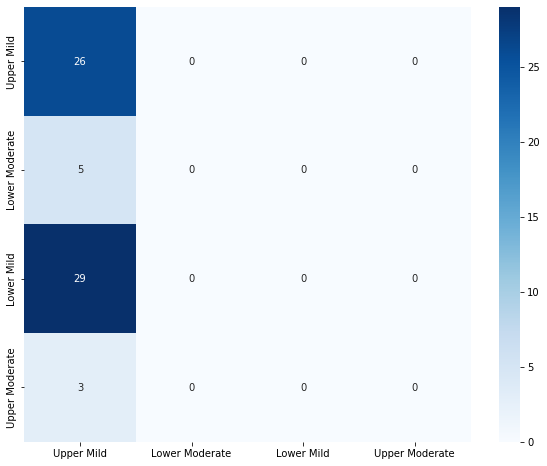

In [107]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(full_body_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [108]:
body_convLSTM = tf.keras.models.load_model(body_convlstm_model_path)
y_pred = body_convLSTM.predict(full_body_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [109]:
_, acc, auc, precision, recall, f1 = body_cnnlstm.evaluate(full_body_X_test, full_body_y_test, verbose=0)
bal_acc = balanced_accuracy_score(full_body_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 41.27% 
Balanced Accuracy: 25.00% 
ROC/AUC: 0.75 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.15


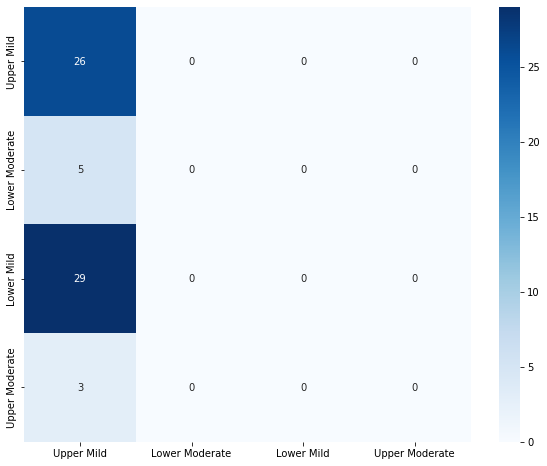

In [110]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(full_body_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [111]:
body_rcnn = tf.keras.models.load_model(body_rcnn_model_path)
y_pred = body_rcnn.predict(full_body_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [112]:
_, acc, auc, precision, recall, f1 = body_rcnn.evaluate(full_body_X_test, full_body_y_test, verbose=0)
bal_acc = balanced_accuracy_score(full_body_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 19.05% 
Balanced Accuracy: 18.81% 
ROC/AUC: 0.57 
Precision: 0.21 
Recall: 0.13 
F1 score: 0.13


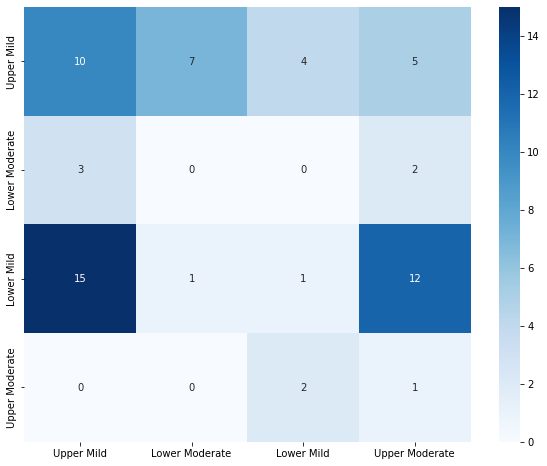

In [113]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(full_body_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

### Uni-Modal Face (action units)

In [114]:
face_cnnlstm = tf.keras.models.load_model(face_cnnlstm_model_path)
y_pred = face_cnnlstm.predict(face_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [115]:
_, acc, auc, precision, recall, f1 = face_cnnlstm.evaluate(face_X_test, face_y_test, verbose=0)
bal_acc = balanced_accuracy_score(face_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 36.67% 
Balanced Accuracy: 22.92% 
ROC/AUC: 0.67 
Precision: 0.59 
Recall: 0.27 
F1 score: 0.14


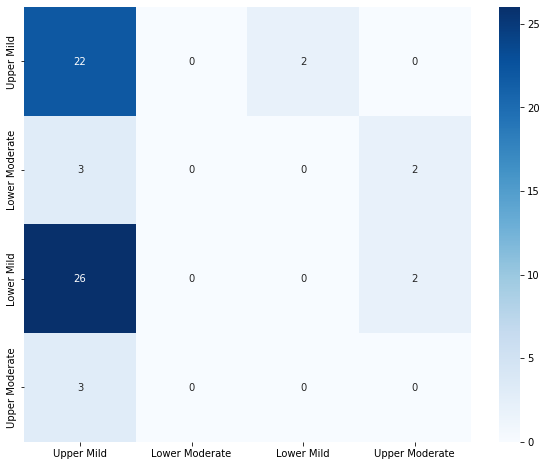

In [116]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(face_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [117]:
face_convLSTM = tf.keras.models.load_model(face_convlstm_model_path)
y_pred = face_convLSTM.predict(face_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [118]:
_, acc, auc, precision, recall, f1 = face_convLSTM.evaluate(face_X_test, face_y_test, verbose=0)
bal_acc = balanced_accuracy_score(face_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 36.67% 
Balanced Accuracy: 30.83% 
ROC/AUC: 0.65 
Precision: 1.00 
Recall: 0.10 
F1 score: 0.23


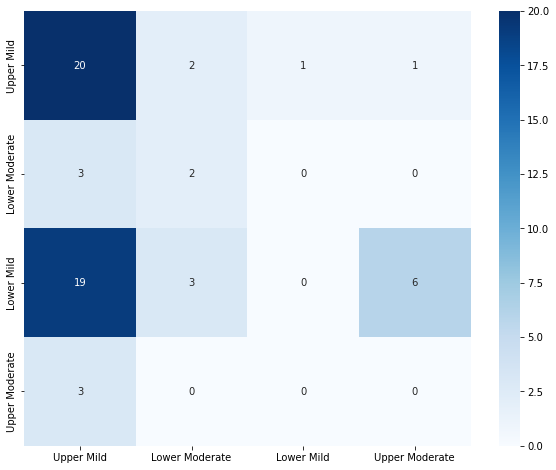

In [119]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(face_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [120]:
face_rcnn = tf.keras.models.load_model(face_rcnn_model_path)
y_pred = face_rcnn.predict(face_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [121]:
_, acc, auc, precision, recall, f1 = face_rcnn.evaluate(face_X_test, face_y_test, verbose=0)
bal_acc = balanced_accuracy_score(face_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 36.67% 
Balanced Accuracy: 22.92% 
ROC/AUC: 0.53 
Precision: 0.80 
Recall: 0.07 
F1 score: 0.15


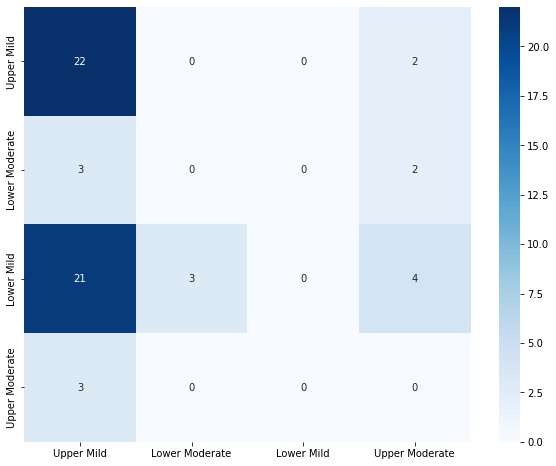

In [122]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(face_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

### Uni-modal Head (pose)

In [123]:
head_cnnlstm = tf.keras.models.load_model(head_cnnlstm_model_path)
y_pred = head_cnnlstm.predict(head_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [124]:
_, acc, auc, precision, recall, f1 = head_cnnlstm.evaluate(head_X_test, head_y_test, verbose=0)
bal_acc = balanced_accuracy_score(head_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 40.00% 
Balanced Accuracy: 25.00% 
ROC/AUC: 0.74 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.15


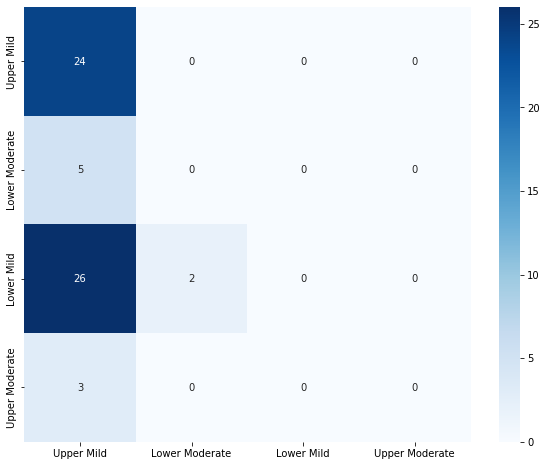

In [125]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(head_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [126]:
head_convLSTM = tf.keras.models.load_model(head_convLSTM_model_path)
y_pred = head_convLSTM.predict(head_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [127]:
_, acc, auc, precision, recall, f1 = head_convLSTM.evaluate(head_X_test, head_y_test, verbose=0)
bal_acc = balanced_accuracy_score(head_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 40.00% 
Balanced Accuracy: 25.00% 
ROC/AUC: 0.75 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.14


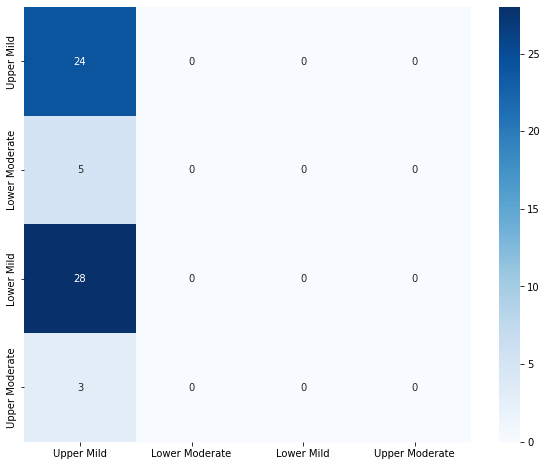

In [128]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(head_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [129]:
head_rcnn = tf.keras.models.load_model(head_rcnn_model_path)
y_pred = head_rcnn.predict(head_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [130]:
_, acc, auc, precision, recall, f1 = head_rcnn.evaluate(head_X_test, head_y_test, verbose=0)
bal_acc = balanced_accuracy_score(head_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 50.00% 
Balanced Accuracy: 30.06% 
ROC/AUC: 0.72 
Precision: 0.80 
Recall: 0.07 
F1 score: 0.26


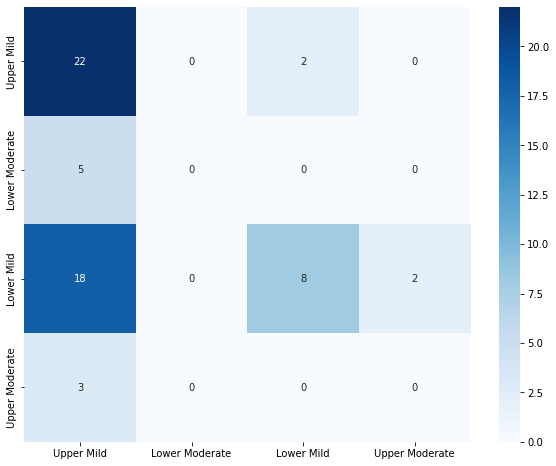

In [131]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(head_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

### Early Fusion (Feature Level)

In [132]:
early_cnnlstm = tf.keras.models.load_model(early_cnnlstm_model_path)
y_pred = early_cnnlstm.predict(early_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [133]:
_, acc, auc, precision, recall, f1 = early_cnnlstm.evaluate(early_X_test, early_y_test, verbose=0)
bal_acc = balanced_accuracy_score(early_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 46.67% 
Balanced Accuracy: 28.57% 
ROC/AUC: 0.65 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.21


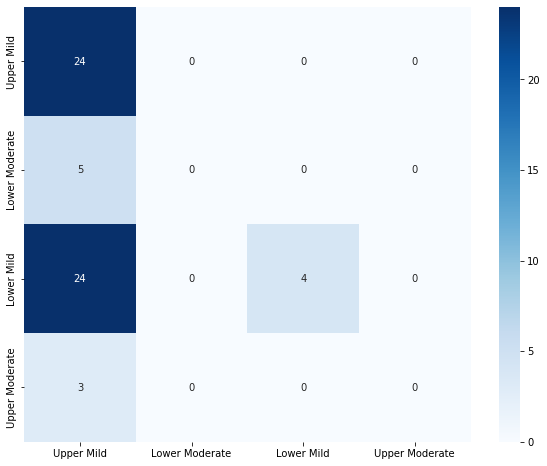

In [134]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(early_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [135]:
early_convLSTM = tf.keras.models.load_model(early_convLSTM_model_path)
y_pred = early_convLSTM.predict(early_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [136]:
_, acc, auc, precision, recall, f1 = early_convLSTM.evaluate(early_X_test, early_y_test, verbose=0)
bal_acc = balanced_accuracy_score(early_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 40.00% 
Balanced Accuracy: 25.00% 
ROC/AUC: 0.61 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.14


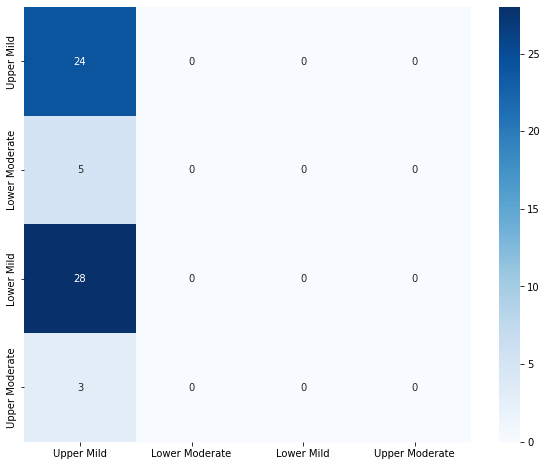

In [137]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(early_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [138]:
early_rcnn = tf.keras.models.load_model(early_rcnn_model_path)
y_pred = early_rcnn.predict(early_X_test)
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [139]:
_, acc, auc, precision, recall, f1 = early_rcnn.evaluate(early_X_test, early_y_test, verbose=0)
bal_acc = balanced_accuracy_score(early_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 36.67% 
Balanced Accuracy: 22.92% 
ROC/AUC: 0.65 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.15


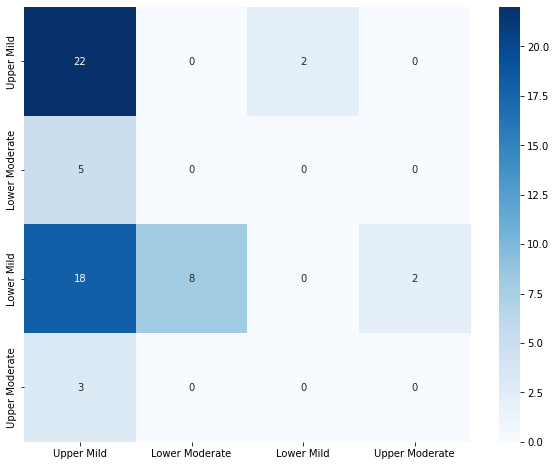

In [140]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(early_y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

### Late Fusion (Decision Level)

In [141]:
late_cnnlstm = tf.keras.models.load_model(late_cnnlstm_model_path)
y_pred = late_cnnlstm.predict([body_X_test, face_X_test, head_X_test])
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [143]:
_, acc, auc, precision, recall, f1 = late_cnnlstm.evaluate([body_X_test, face_X_test, head_X_test], y_test, verbose=0)
bal_acc = balanced_accuracy_score(early_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 31.67% 
Balanced Accuracy: 19.05% 
ROC/AUC: 0.69 
Precision: 0.60 
Recall: 0.20 
F1 score: 0.20


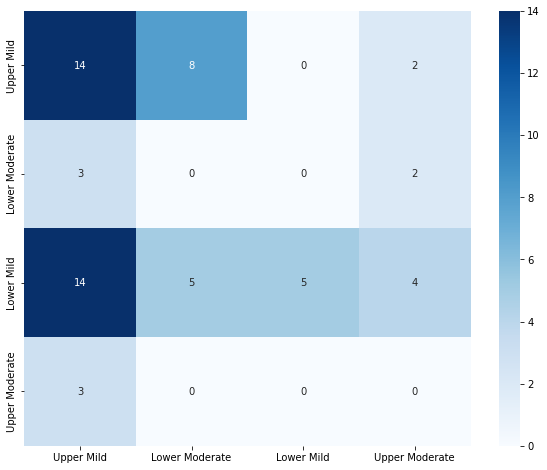

In [144]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [145]:
late_convlstm = tf.keras.models.load_model(late_convlstm_model_path)
y_pred = late_convlstm.predict([body_X_test, face_X_test, head_X_test])
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [146]:
_, acc, auc, precision, recall, f1 = late_convlstm.evaluate([body_X_test, face_X_test, head_X_test], y_test, verbose=0)
bal_acc = balanced_accuracy_score(early_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 40.00% 
Balanced Accuracy: 28.96% 
ROC/AUC: 0.66 
Precision: 0.71 
Recall: 0.17 
F1 score: 0.21


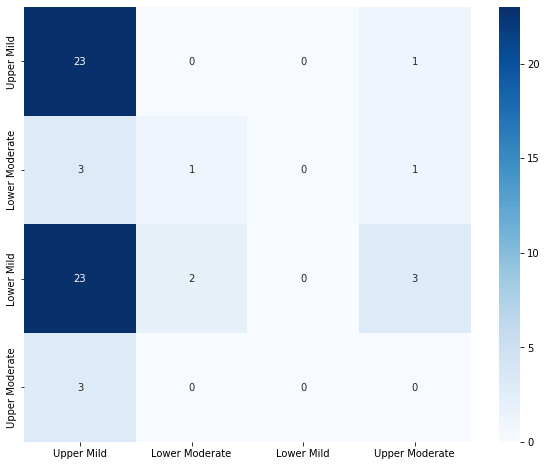

In [147]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

In [148]:
late_rcnn = tf.keras.models.load_model(late_rcnn_model_path)
y_pred = late_rcnn.predict([body_X_test, face_X_test, head_X_test])
i = 0
for pred in y_pred:
    index = np.argmax(pred)
    tmp = np.array([0, 0, 0, 0])
    tmp[index] = 1
    y_pred[i] = tmp
    i += 1
y_pred = y_pred.astype(int)

In [149]:
_, acc, auc, precision, recall, f1 = late_rcnn.evaluate([body_X_test, face_X_test, head_X_test], y_test, verbose=0)
bal_acc = balanced_accuracy_score(early_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 28.33% 
Balanced Accuracy: 17.41% 
ROC/AUC: 0.53 
Precision: 0.30 
Recall: 0.22 
F1 score: 0.16


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

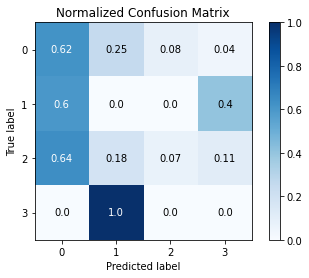

In [162]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

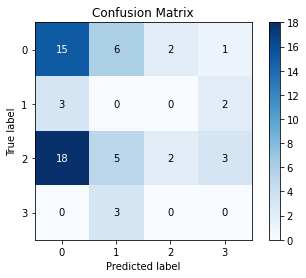

In [163]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

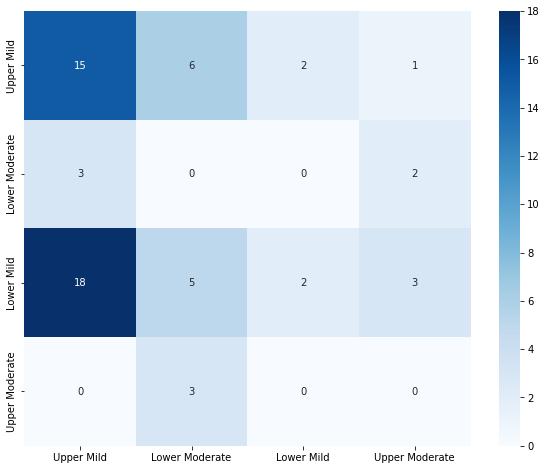

In [150]:
labels = ['Upper Mild', 'Lower Moderate', 'Lower Mild','Upper Moderate']    

fig, ax = plt.subplots(figsize=(10,8))

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)

ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels)
plt.show()

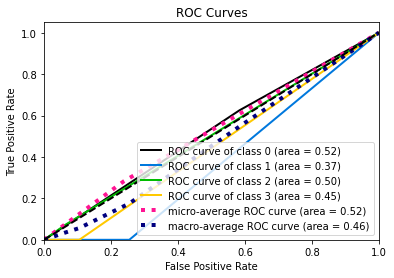

In [165]:
skplt.metrics.plot_roc_curve(y_test.argmax(axis=1), y_pred)
plt.show()

In [151]:
print('Dirichlet Markov Ensemble:\n')
d = dirichletEnsemble.describe()

Dirichlet Markov Ensemble:

CNN+Bidirectional LSTM Body Model (weight: 0.0559)
CNN+Bidirectional LSTM Face Model (weight: 0.1831)
CNN+Bidirectional LSTM Head Model (weight: 0.0256)
ConvLSTM Body Model (weight: 0.0334)
ConvLSTM Face Model (weight: 0.0768)
ConvLSTM Head Model (weight: 0.1406)
RCNN Body Model (weight: 0.0024)
RCNN Face Model (weight: 0.3677)
RCNN Head Model (weight: 0.1145)

Accuracy: 53.33% 
Balanced Accuracy: 32.14% 
ROC/AUC: 0.62 
Precision: 0.39 
Recall: 0.32 
F1 score: 0.27
